# Figure 3 - Tissue specificity of fibroblasts

In [1]:
from numba import set_num_threads

set_num_threads(16)

In [996]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
import sys
from tqdm.auto import tqdm

from plotnine import *
import matplotlib.pyplot as plt

In [3]:
from harmony import harmonize

In [4]:
from pathlib import Path

sys.path.append(str(Path.home() / 'Code/sctoolkit'))

In [1011]:
from sctoolkit.utils import sort_by_correlation, run_spring, dotplot_spring
from sctoolkit.specificity import get_gene_specificity_metricsv2
from sctoolkit.sctransform import sctransform
from sctoolkit.utils import run_spring, dotplot_spring, sort_by_correlation, plot_significance_dotplot
from sctoolkit.revigo import revigo
from sctoolkit.proportions import plot_proportion_barplot, dirichletreg, plot_proportion_barplot_with_ncells, get_proportions_per_channel

from sctoolkit.modules import find_modules, tag_with_score, sort_module_dict

In [6]:
sc.set_figure_params(dpi=100)
sc.settings.figdir = 'figures/'

## Read data

In [ ]:
adata = sc.read('adata.h5ad')

In [ ]:
omim = pd.read_pickle(Path.home() / 'Code/omim_topics/omim_texts.pkl')[['title', 'genes', 'mims']]

## Adipocytes

In [ ]:
adi = sc.read('adipocytes.h5ad')

In [1502]:
pd.crosstab(adi.obs.Tissue, adi.obs['Participant ID']).T

Tissue          Breast  Esophagus muscularis  Heart  Skeletal muscle
Participant ID                                                      
GTEX-1CAMS          40                     0      0                0
GTEX-1HSMQ           0                   169      0               43
GTEX-1ICG6           0                     3     29                0
GTEX-1R9PN        1721                     0      0                0
GTEX-13N11           0                     0    113                0
GTEX-15RIE           0                     0     51               19
GTEX-144GM           0                     3      0                0
GTEX-145ME           0                     0      0               97

In [1503]:
sc.pp.combat(adi, key='Participant ID')

Found 1543 genes with zero variance.


/home/gokcen/.miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in true_divide
/home/gokcen/.miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide


In [1504]:
sc.tl.rank_genes_groups(adi, 'Tissue', use_raw=False)

/home/gokcen/.miniconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2


In [1507]:
de = sc.get.rank_genes_groups_df(adi, group=None, log2fc_min=.5, pval_cutoff=0.1)
de.to_excel('adipocyte-DE.xlsx', index=False)

## T Cells

In [ ]:
tcell = sc.read('tcells.h5ad')

In [1479]:
pd.crosstab(tcell.obs.Tissue, tcell.obs['Participant ID']).T

Tissue          Esophagus mucosa  Esophagus muscularis  Heart  Lung  Prostate
Participant ID                                                               
GTEX-1HSMQ                     0                    68      0   143        72
GTEX-1I1GU                     0                     0      0     0       314
GTEX-1ICG6                     0                    75     26     0         0
GTEX-12BJ1                     0                     0      0     0       228
GTEX-13N11                     0                     0    171   345         0
GTEX-15CHR                     0                     0      0   125         0
GTEX-15RIE                     0                     0    160     0         0
GTEX-15SB6                   885                     0      0     0         0
GTEX-16BQI                   738                     0      0     0         0
GTEX-144GM                     0                   107      0     0         0
GTEX-145ME                     9                     0      0     0         0

In [1480]:
sc.pp.combat(tcell, key='Participant ID')

Found 1609 genes with zero variance.


/home/gokcen/.miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in true_divide
/home/gokcen/.miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide


In [1481]:
sc.tl.rank_genes_groups(tcell, 'Tissue', use_raw=False)

In [1510]:
de = sc.get.rank_genes_groups_df(tcell, group=None, log2fc_min=.5, pval_cutoff=0.1)
de.to_excel('tcell-DE.xlsx', index=False)

## Fibroblasts

In [8]:
process = False

if process:
    fib = adata[adata.obs['Broad cell type'].str.startswith('Fibroblast')].copy()

    sc.pp.highly_variable_genes(fib, n_top_genes=2000)
    sc.pp.pca(fib)
    fib.obsm['X_harmony'] = harmonize(fib.obsm['X_pca'], fib.obs, 'Participant ID')
    sc.pp.neighbors(fib, use_rep='X_harmony')
    sc.tl.umap(fib)
    
    fib.layers['scaled'] = fib.X.copy()
    sc.pp.scale(fib, max_value=10, layer='scaled')
    fib.write('fibroblasts.h5ad')
else:
    fib = sc.read('fibroblasts.h5ad')

In [ ]:
plt.rcParams['figure.figsize'] = (10,10)

f, axs = plt.subplots(2, 4, figsize=(20,10))
axs = axs.flatten()
for t, ax in zip(fib.obs.Tissue.cat.categories, axs):
    sc.pl.umap(fib, color=['Tissue'], ncols=2, wspace=0.5, size=10, groups=t, ax=ax, show=False, title=t, legend_loc='none', na_color='#F0F0F0', add_outline=True, outline_width=(0.01,0.001), frameon=False)

plt.rcParams['figure.figsize'] = (4,4)

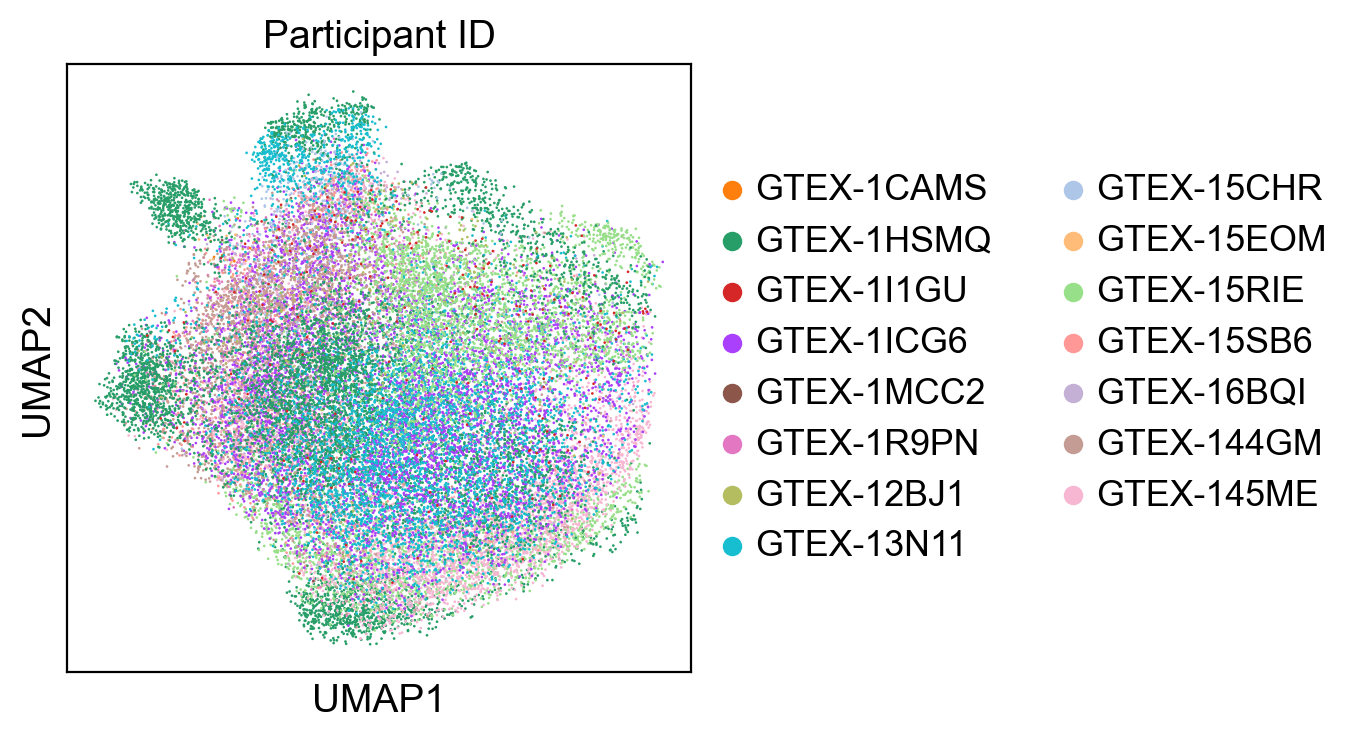

In [12]:
sc.pl.umap(fib, color=['Participant ID'])

In [17]:
pd.options.display.max_rows = 20

## Pseudobulk DE

In [100]:
ch = fib.obs['channel'].value_counts()>=30
ch = ch[ch].index.astype(str)

In [101]:
fib_df = fib[fib.obs['channel'].isin(ch)].copy()

In [102]:
fib_ch = sc.AnnData(pd.DataFrame(fib_df.X.A, columns=fib_df.var_names, index=fib_df.obs_names).groupby(fib_df.obs['channel'], observed=True).mean())
fib_ch.layers['scaled'] = pd.DataFrame(fib_df.layers['scaled'], columns=fib_df.var_names, index=fib_df.obs_names).groupby(fib_df.obs['channel'], observed=True).mean()

/home/gokcen/.miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.


In [103]:
t2t = adata.obs[['Tissue', 'tissue']].drop_duplicates().set_index('tissue').Tissue.to_dict()

In [104]:
fib_ch.obs['tissue'] = [x.split('_')[0] for x in fib_ch.obs.index]
fib_ch.obs['Tissue'] = [t2t[x] for x in fib_ch.obs['tissue']]
fib_ch.obs['prep'] = [x.split('_')[1] for x in fib_ch.obs.index]
fib_ch.obs['Participant ID'] = [x.split('_')[2] for x in fib_ch.obs.index]
fib_ch._sanitize()
fib_ch.obs

/home/gokcen/.miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'tissue' as categorical
/home/gokcen/.miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'Tissue' as categorical
/home/gokcen/.miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'prep' as categorical
/home/gokcen/.miniconda3/lib/python3

tissue           Tissue prep  \
channel                                                               
skeletalmuscle_CST_GTEX-1HSMQ  skeletalmuscle  Skeletal muscle  CST   
skeletalmuscle_EZ_GTEX-1HSMQ   skeletalmuscle  Skeletal muscle   EZ   
skeletalmuscle_NST_GTEX-1HSMQ  skeletalmuscle  Skeletal muscle  NST   
skeletalmuscle_TST_GTEX-1HSMQ  skeletalmuscle  Skeletal muscle  TST   
skeletalmuscle_CST_GTEX-15RIE  skeletalmuscle  Skeletal muscle  CST   
...                                       ...              ...  ...   
prostate_CST_GTEX-12BJ1              prostate         Prostate  CST   
prostate_TST_GTEX-12BJ1              prostate         Prostate  TST   
skin_CST_GTEX-1HSMQ                      skin             Skin  CST   
skin_NST_GTEX-1HSMQ                      skin             Skin  NST   
skin_TST_GTEX-1HSMQ                      skin             Skin  TST   

                              Participant ID  
channel                                       
skeletalmuscle_CST_GTEX-1HSMQ     GTEX-1HSMQ  
skeletalmuscle_EZ_GTEX-1HSMQ      GTEX-1HSMQ  
skeletalmuscle_NST_GTEX-1HSMQ     GTEX-1HSMQ  
skeletalmuscle_TST_GTEX-1HSMQ     GTEX-1HSMQ  
skeletalmuscle_CST_GTEX-15RIE     GTEX-15RIE  
...                                      ...  
prostate_CST_GTEX-12BJ1           GTEX-12BJ1  
prostate_TST_GTEX-12BJ1           GTEX-12BJ1  
skin_CST_GTEX-1HSMQ               GTEX-1HSMQ  
skin_NST_GTEX-1HSMQ               GTEX-1HSMQ  
skin_TST_GTEX-1HSMQ               GTEX-1HSMQ  

[70 rows x 4 columns]

In [105]:
fib_ch.uns['Tissue_colors'] = adata.uns['Tissue_colors']

In [106]:
sc.tl.rank_genes_groups(fib_ch, 'Tissue', use_raw=False)

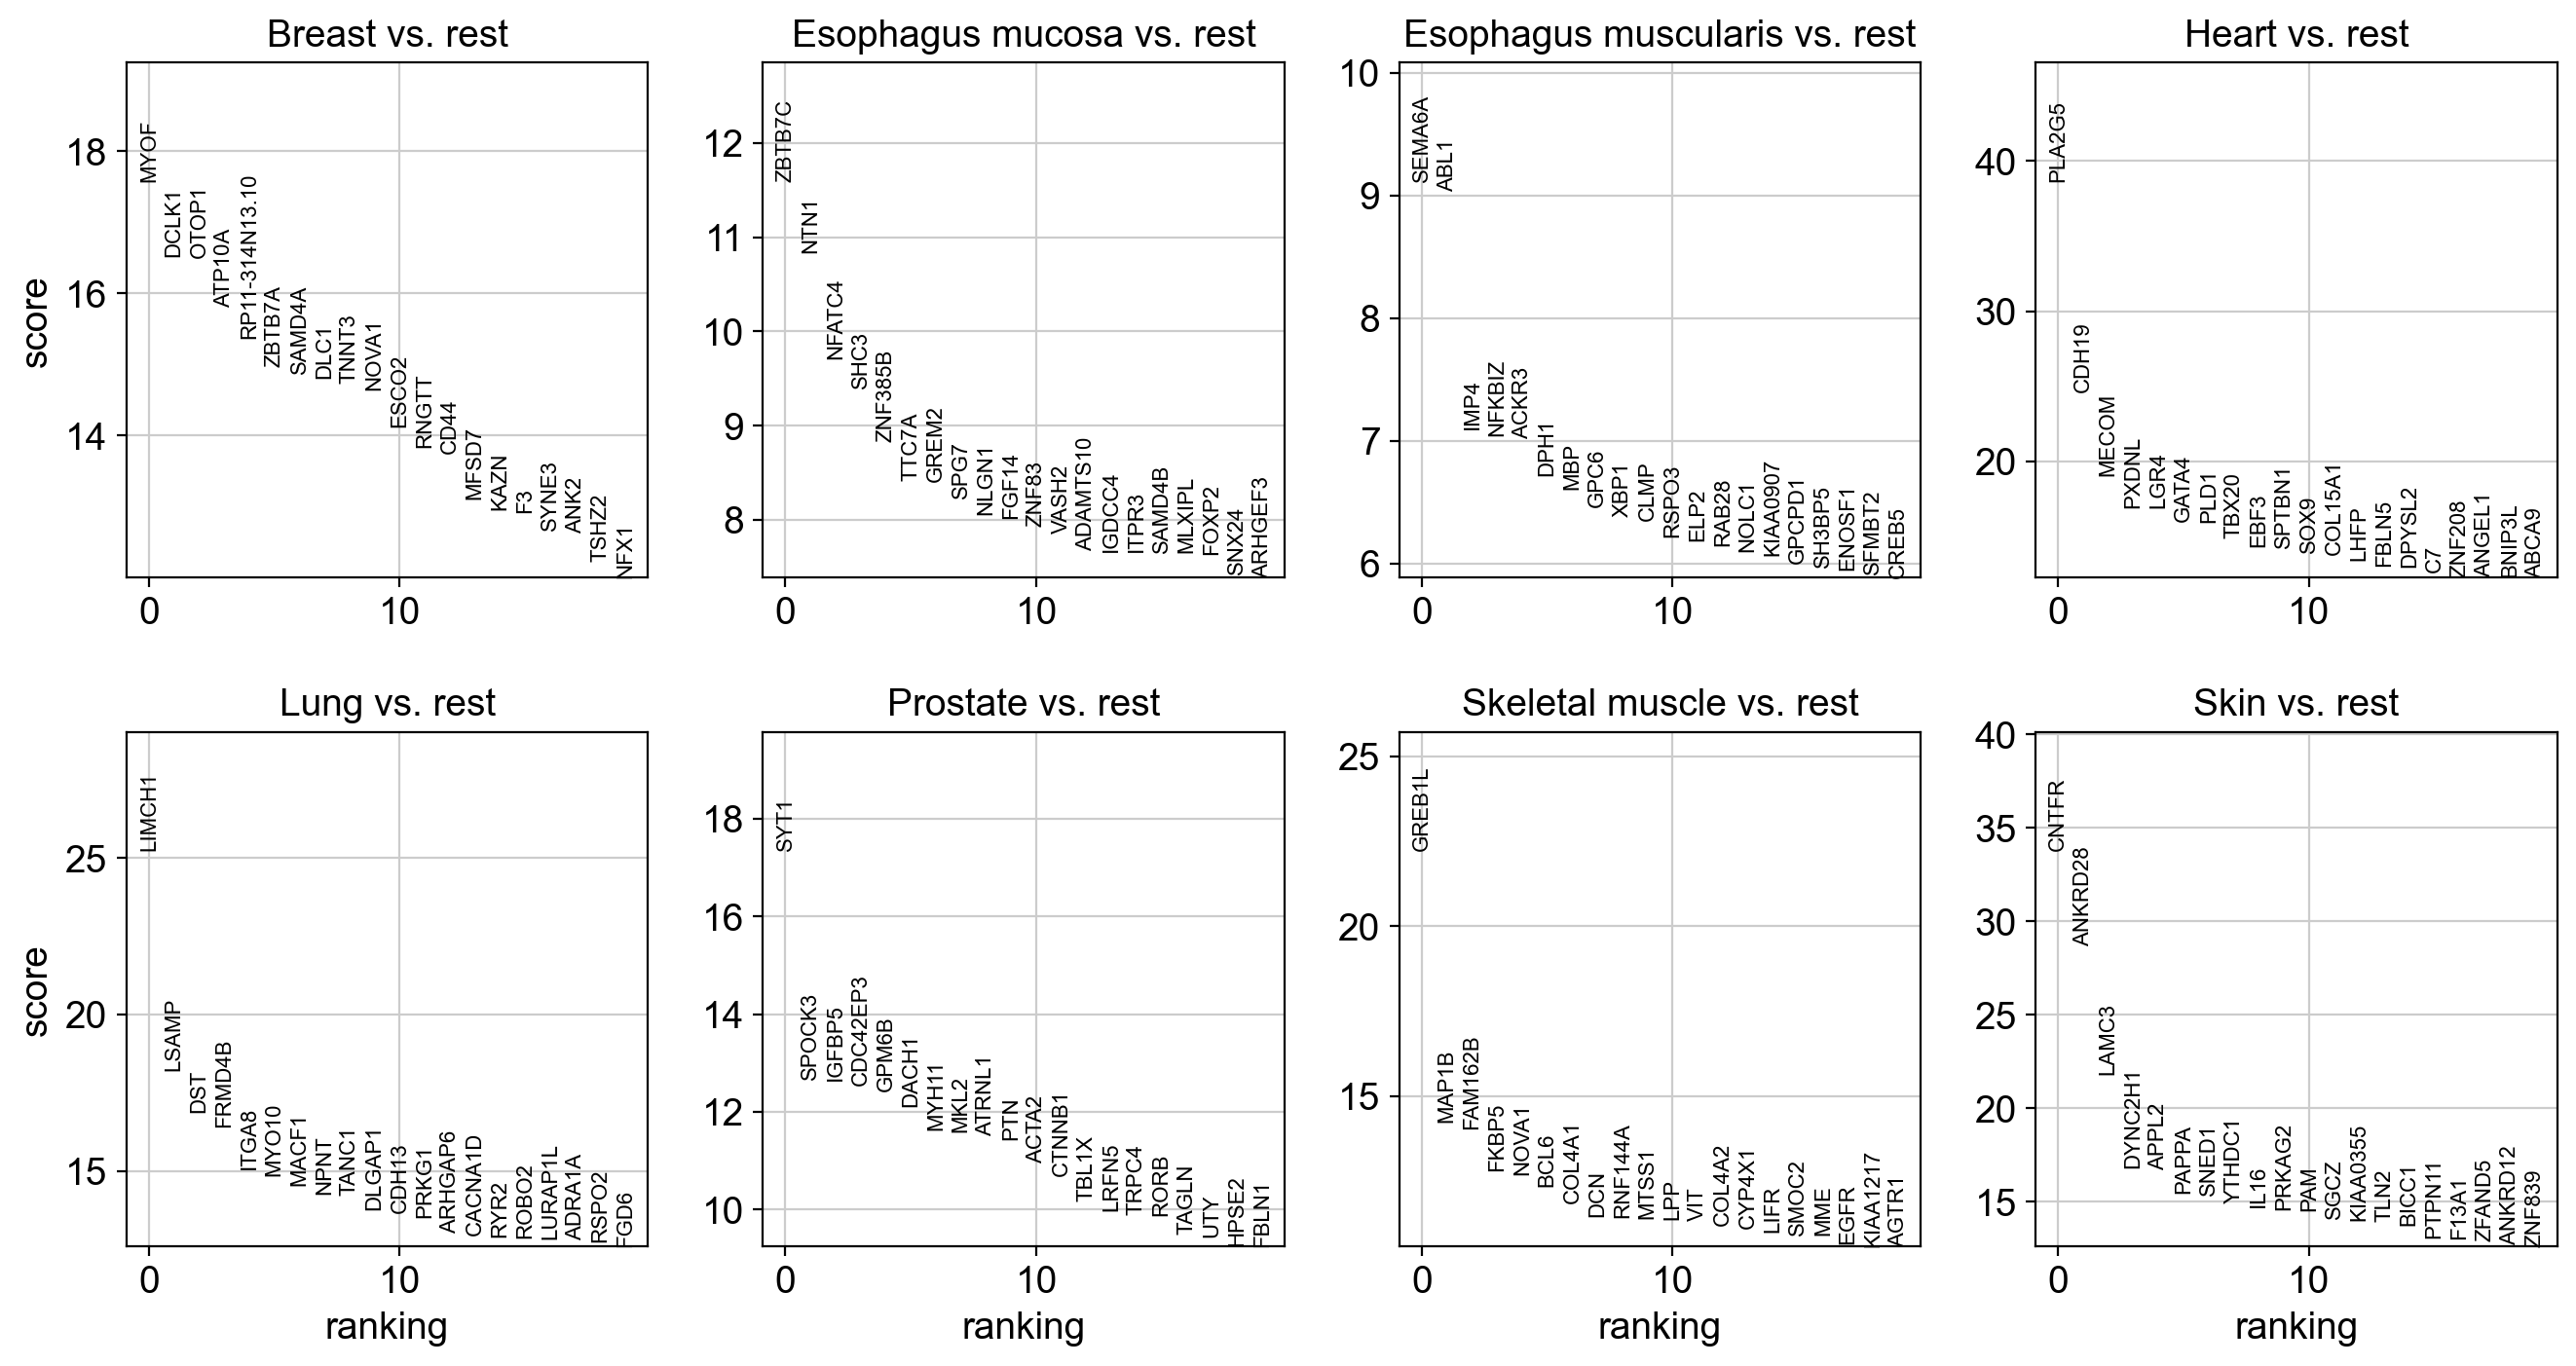

In [107]:
sc.pl.rank_genes_groups(fib_ch, sharey=False)

In [1651]:
fib.obs['tissue_granular'] = fib.obs.Tissue.astype(str) + ' - ' + fib.obs['Granular cell type'].astype(str)
fib._sanitize()

/home/gokcen/.miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'tissue_granular' as categorical


In [ ]:
sc.pl.umap(fib[fib.obs['Granular cell type'].str.startswith('Fibroblast')], color=['tissue_granular'], frameon=False)

In [ ]:
plt.rcParams['figure.figsize'] = (10,10)
ff = fib[fib.obs['Granular cell type'].str.startswith('Fibroblast')].copy()
f, axs = plt.subplots(2, 7, figsize=(30,10))
axs = axs.flatten()
for t, ax in zip(ff.obs.tissue_granular.cat.categories, axs):
    sc.pl.umap(ff, color=['tissue_granular'], ncols=2, wspace=0.5, size=20, groups=t, ax=ax, show=False, title=t, legend_loc='none', na_color='#F0F0F0', add_outline=True, outline_width=(0.01,0.001), frameon=False)

plt.rcParams['figure.figsize'] = (4,4)

In [109]:
df = sc.get.rank_genes_groups_df(fib_ch, group=None, log2fc_min=1, pval_cutoff=0.01)
markers = df.loc[df.groupby('group').scores.nlargest(3).reset_index().level_1].names

## Load the DE results

In [1666]:
de = pd.read_pickle('../../DE/de_broad.pkl')
de = de[(de.celltype == 'Fibroblast') & (de.pvals_fdr<0.01) & (de.log2FC>1)].reset_index(drop=True)
de

celltype     gene      tstat          pvals      pvals_fdr    log2FC  \
0      Fibroblast    DCLK1  44.842999  1.168152e-223  1.100812e-220  6.196599   
1      Fibroblast     DLC1  39.855576  4.553463e-198  3.039437e-195  3.542841   
2      Fibroblast   COL6A2  34.527515  7.434813e-163  2.769900e-160  4.777704   
3      Fibroblast    NOVA1  34.169777  5.737327e-161  1.998086e-158  4.261243   
4      Fibroblast   COL6A1  33.881268  5.973993e-159  1.953130e-156  4.645612   
...           ...      ...        ...            ...            ...       ...   
11213  Fibroblast  TRABD2B   2.941623   3.400235e-03   9.542991e-03  1.647833   
11214  Fibroblast     FPGS   2.937376   3.441608e-03   9.636501e-03  1.187565   
11215  Fibroblast     LVRN   2.936394   3.462620e-03   9.683133e-03  3.452156   
11216  Fibroblast     CALU   2.935938   3.455249e-03   9.667735e-03  1.004935   
11217  Fibroblast   MALRD1   2.929501   3.526743e-03   9.828876e-03  1.133379   

       fraction_group  fraction_rest  mean_expressed  spring_score  tissue  \
0            0.824176       0.036197        1.450059      2.507510  Breast   
1            0.846154       0.176628        1.380631      1.787184  Breast   
2            0.720391       0.053849        1.122492      2.071148  Breast   
3            0.736264       0.091275        1.221809      1.956967  Breast   
4            0.706960       0.055301        1.060982      2.016763  Breast   
...               ...            ...             ...           ...     ...   
11213        0.043478       0.015006        0.753421      0.200903    Skin   
11214        0.051040       0.022509        0.693147      0.168175    Skin   
11215        0.020794       0.002293        0.829881      0.274175    Skin   
11216        0.069943       0.036265        0.736981      0.158012    Skin   
11217        0.066163       0.031055        0.712951      0.158441    Skin   

           marker  spring_score_nonzero  significant  
0                              2.507510         True  
1                              1.787184         True  
2      Fibroblast              2.071148         True  
3                              1.956967         True  
4      Fibroblast              2.016763         True  
...           ...                   ...          ...  
11213                          0.200903         True  
11214                          0.168175         True  
11215                          0.274175         True  
11216                          0.158012         True  
11217                          0.158441         True  

[11218 rows x 14 columns]

In [1705]:
common_genes = de.gene.value_counts()
common_genes = common_genes[common_genes>6].index

In [1706]:
common_genes

Index(['DCLK1', 'MXRA8', 'NFATC4', 'SPON2', 'IGFBP6', 'OLFML3', 'FST', 'CFD',
       'C1S', 'FGF7',
       ...
       'PTPRG', 'ADRA1B', 'IGFBP5', 'ADH1B', 'CELF2', 'CRLF1', 'SPRY2',
       'BMPER', 'PIWIL4', 'SMIM3'],
      dtype='object', length=200)

In [1667]:
common_genes = de[de.gene.isin(common_genes)].groupby('gene').spring_score.mean().sort_values(ascending=False).index
common_genes = common_genes[:15]

idx = sort_by_correlation(fib[:, common_genes].X.A, rows=False, optimal_ordering=False)

common_genes = np.array(common_genes)[idx]
common_genes

array(['FBLN1', 'SLIT2', 'PID1', 'DCN', 'ABCA6', 'LAMA2', 'NEGR1',
       'COL5A2', 'COL1A2', 'COL3A1', 'COL6A3', 'COL6A2', 'COL6A1',
       'SVEP1', 'DCLK1'], dtype=object)

In [1669]:
de[de.gene.isin(common_genes)].to_excel('fibro-common.xlsx', index=False)

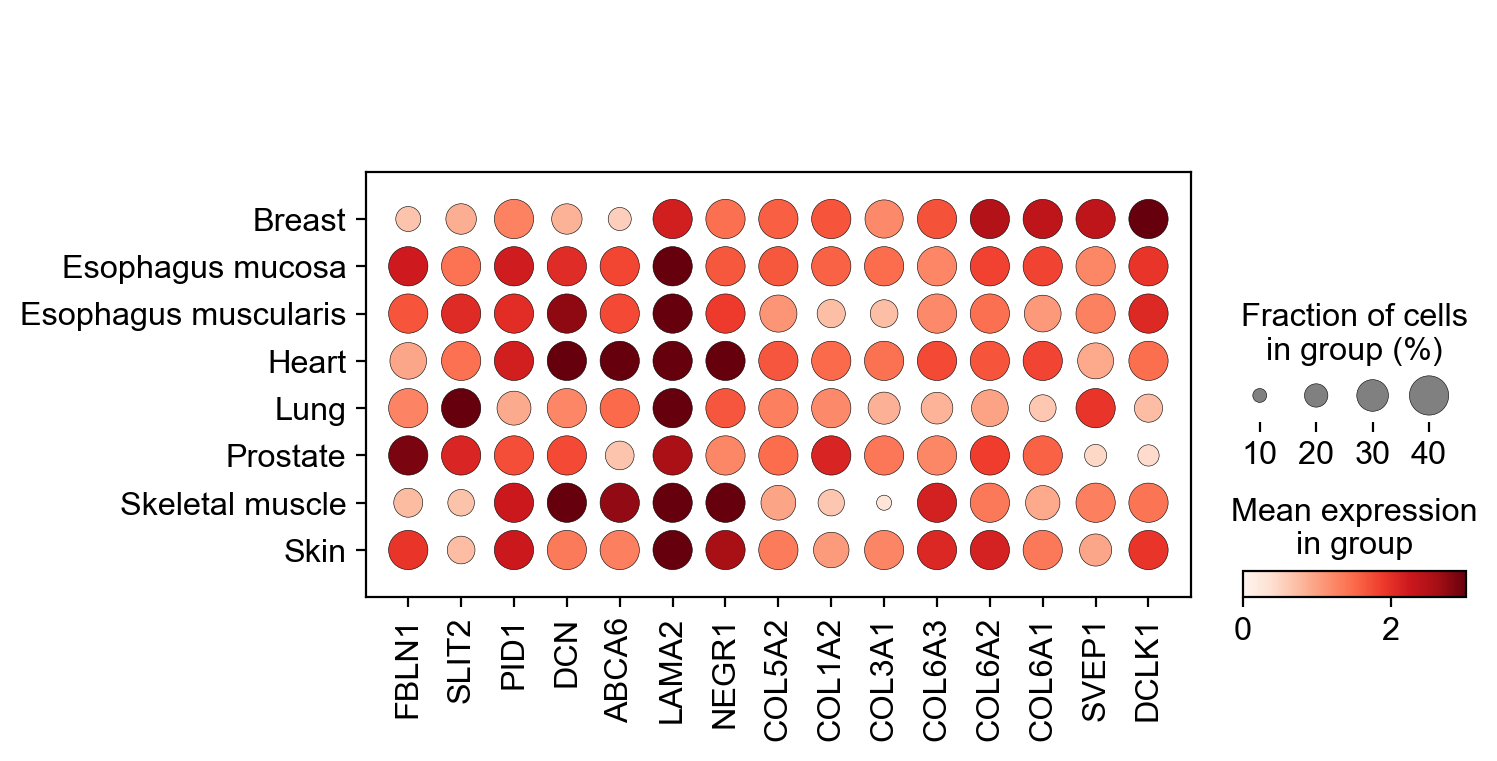

In [949]:
sc.pl.dotplot(fib, common_genes, 'Tissue', vmin=0, vmax=3, dot_max=.4, save='-fibroblast-xtissue-A-tissueshared.pdf')

In [139]:
common_genes

array(['FBLN1', 'SLIT2', 'PID1', 'DCN', 'ABCA6', 'LAMA2', 'NEGR1',
       'COL5A2', 'COL1A2', 'COL3A1', 'COL6A3', 'COL6A2', 'COL6A1',
       'SVEP1', 'DCLK1'], dtype=object)

In [140]:
pd.options.display.max_colwidth = 100

In [141]:
sc.queries.enrich(common_genes.tolist(), gprofiler_kwargs={'no_evidences': False, 'sources': ['GO:BP', 'REAC', 'KEGG']}).head(30)

source              native  \
0    REAC  REAC:R-HSA-3000178   
1    REAC  REAC:R-HSA-1474244   
2    REAC  REAC:R-HSA-8948216   
3    REAC  REAC:R-HSA-2022090   
4    REAC  REAC:R-HSA-1442490   
5   GO:BP          GO:0030198   
6   GO:BP          GO:0043062   
7   GO:BP          GO:0045229   
8    REAC  REAC:R-HSA-1474228   
9    REAC  REAC:R-HSA-1650814   
10   REAC   REAC:R-HSA-216083   
11   REAC  REAC:R-HSA-1474290   
12   KEGG          KEGG:04974   
13   REAC   REAC:R-HSA-419037   
14  GO:BP          GO:0030199   
15   REAC   REAC:R-HSA-186797   
16   REAC   REAC:R-HSA-375165   
17   KEGG          KEGG:04512   
18   REAC  REAC:R-HSA-8874081   
19   REAC  REAC:R-HSA-8875878   
20   REAC  REAC:R-HSA-9006934   
21   REAC  REAC:R-HSA-3000171   
22   KEGG          KEGG:04510   
23   REAC  REAC:R-HSA-9675108   
24   REAC  REAC:R-HSA-6806834   
25   REAC  REAC:R-HSA-3000170   
26   KEGG          KEGG:05165   
27   KEGG          KEGG:04151   
28  GO:BP          GO:0097435   
29   REAC   REAC:R-HSA-422475   

                                                            name  \
0                                              ECM proteoglycans   
1                              Extracellular matrix organization   
2                                   Collagen chain trimerization   
3   Assembly of collagen fibrils and other multimeric structures   
4                                           Collagen degradation   
5                              extracellular matrix organization   
6                           extracellular structure organization   
7                  external encapsulating structure organization   
8                        Degradation of the extracellular matrix   
9                    Collagen biosynthesis and modifying enzymes   
10                            Integrin cell surface interactions   
11                                            Collagen formation   
12                              Protein digestion and absorption   
13                                            NCAM1 interactions   
14                                  collagen fibril organization   
15                                             Signaling by PDGF   
16                         NCAM signaling for neurite out-growth   
17                                      ECM-receptor interaction   
18                                  MET activates PTK2 signaling   
19                                    MET promotes cell motility   
20                        Signaling by Receptor Tyrosine Kinases   
21                        Non-integrin membrane-ECM interactions   
22                                                Focal adhesion   
23                                    Nervous system development   
24                                              Signaling by MET   
25                                         Syndecan interactions   
26                                Human papillomavirus infection   
27                                    PI3K-Akt signaling pathway   
28                             supramolecular fiber organization   
29                                                 Axon guidance   

         p_value  significant  \
0   5.887237e-13         True   
1   5.644358e-10         True   
2   9.290580e-10         True   
3   6.537965e-09         True   
4   9.772056e-09         True   
5   1.128330e-08         True   
6   1.152687e-08         True   
7   1.202803e-08         True   
8   1.287806e-08         True   
9   1.298826e-08         True   
10  5.246679e-08         True   
11  7.482408e-08         True   
12  9.724897e-08         True   
13  1.694831e-07         True   
14  2.900995e-07         True   
15  6.259303e-07         True   
16  9.881459e-07         True   
17  3.550969e-06         True   
18  7.280776e-06         True   
19  2.413369e-05         True   
20  7.538634e-05         True   
21  1.108263e-04         True   
22  2.140966e-04         True   
23  2.342656e-04         True   
24  3.315048e-04         True   
25  8.158705

In [116]:
common_genes

array(['FBLN1', 'SLIT2', 'PID1', 'DCN', 'ABCA6', 'LAMA2', 'NEGR1',
       'COL5A2', 'COL1A2', 'COL3A1', 'COL6A3', 'COL6A2', 'COL6A1',
       'SVEP1', 'DCLK1'], dtype=object)

## Marker sets

In [1095]:
turley_mouse = { # Fig 1A
    'Pan Adventitial': ['PI16','DPP4'],
    'Pan Parenchymal': ['COL15A1','PENK'],
    'Spleen FRC': ['CCL19','CCL21','BST1'],
    'Bone MSC-OLC': ['CXCL12','LEPR','SP7'],
    'Lung Alveolar': ['NPNT','CES1'],
    'Artery Fib2': ['COMP','FMOD'],
    'Spleen-Liver Red pulp': ['COCH','WT1'],
    'Intestine PDGFR alpha lo': ['FBLN1','SFRP1'],
    'Lung Peribronchial': ['HHIP','ASPN'],
    'Intestine PDGFR alpha hi': ['BMP4','PDGFRA'],
}

In [1106]:
turley_human = { # Fig 4
    'Lung Adventitial': ['PI16', 'CD34', 'HAS1','PLIN2'],
    'Lung Alveolar': ['NPNT','CES1','ADH1B', 'FGFR4'],
    'PDAC-NSCLC LRRC15+ Myofibroblast': ['LRRC15','COL11A1','CTHRC1'],
    'Colitis ADAMDEC1+': ['ADAMDEC1', 'CXCL14'],
    'Colitis CCL19+': ['CCL19','GREM1','TNFSF13B'],
    'COVID19 COL3A1+ Myofibroblast': ['COL3A1','POSTN'],
}

In [1097]:
brenner_human = { # Fig 3
    'SPARC+COL3A1+ C4': ['CTHRC1','COL1A1','KIF26B','MMP13','ADAM12','POSTN','SPARC','COL3A1'],
    'FBLN1+ C5': ['C6','ADH1B','ITM2A','C3','OGN','FBLN1'],
    'PTGS2+SEMA4A+ C8': ['PTGS2','FOSB','ARC','SEMA4A','CXCL2'],
    'CD34+MFAP5+ C9': ['MFAP5','CYP4B1','FBLN2','CD34','PCOLCE2'],
    'CXCL10+CCL19+': ['CCL19','CCL21','CXCL9','RBP5','CD74','CXCL10','HLA-DRA'],
}

In [1098]:
teichmann = { # Fig 3
    'Heart FB1': ['SCN7A', 'BMPER', 'ACSM1'],
    'Heart FB2': ['CFH', 'ID4', 'KCNT2'],
    'Heart FB3': ['PTX3', 'OSMR', 'IL6ST'],
    'Heart FB4': ['POSTN', 'TNC', 'FAP'],
    'Heart FB5': ['FBLN2', 'PCOLCE2'],
    'Heart FB6': ['CD36', 'EGFLAM', 'FTL'],
}

In [1099]:
# https://www.biorxiv.org/content/10.1101/2021.06.03.446915v1.full.pdf
forte_mouse = { # Fig 4
    'Kidney': ['FERMT1', 'PAQR5', 'CLDN4', 'CDH16', 'KCNK1', 'PDZK1IP1', 'GDF15', 'SFN', 'PAX8', 'WNT7B'],
    'Liver': ['VSIG4', 'CD5L', 'HHEX'],
    'Lung': ['RNASE2', 'FGF1', 'FOXF1'],
    'Neonatal heart': ['FRZB', 'COL2A1', 'TBX20'],
    'Testis': ['AKR1C1', 'LHX9', 'CYP11A1'],
}

In [1100]:
muhl_mouse = {
    'Muscle': ['THBS1', 'THBS4', 'COL11A1', 'COL12A1', 'POSTN'],
    'Heart': ['WIF1', 'DKK3', 'CSPG4'],
    'Colon': ['TNC', 'LAMA5', 'CD34', 'CNN1'],
    'Bladder': ['TNC', 'DKK2', 'CD34', 'CSPG4']
}

In [1101]:
marker_df = pd.concat([
    pd.DataFrame.from_dict(brenner_human, orient='index').reset_index().melt('index', value_name='gene').rename(columns={'index': 'marker_state'}).drop('variable', axis=1).dropna().assign(marker_source='Brenner'),
    pd.DataFrame.from_dict(turley_human, orient='index').reset_index().melt('index', value_name='gene').rename(columns={'index': 'marker_state'}).drop('variable', axis=1).dropna().assign(marker_source='Turley human'),
    pd.DataFrame.from_dict(turley_mouse, orient='index').reset_index().melt('index', value_name='gene').rename(columns={'index': 'marker_state'}).drop('variable', axis=1).dropna().assign(marker_source='Turley mouse'),
    pd.DataFrame.from_dict(teichmann, orient='index').reset_index().melt('index', value_name='gene').rename(columns={'index': 'marker_state'}).drop('variable', axis=1).dropna().assign(marker_source='Teichmann'),
    pd.DataFrame.from_dict(forte_mouse, orient='index').reset_index().melt('index', value_name='gene').rename(columns={'index': 'marker_state'}).drop('variable', axis=1).dropna().assign(marker_source='Forte et al. mouse'),    
    pd.DataFrame.from_dict(muhl_mouse, orient='index').reset_index().melt('index', value_name='gene').rename(columns={'index': 'marker_state'}).drop('variable', axis=1).dropna().assign(marker_source='Muhl mouse'),    
])

marker_df = marker_df.groupby('gene').agg(lambda x: ', '.join(x)).reset_index()
marker_df

gene              marker_state          marker_source
0       ACSM1                 Heart FB1              Teichmann
1      ADAM12          SPARC+COL3A1+ C4                Brenner
2    ADAMDEC1                  Colitis1           Turley human
3       ADH1B  FBLN1+ C5, Lung Alveolar  Brenner, Turley human
4      AKR1C1                    Testis     Forte et al. mouse
..        ...                       ...                    ...
99   TNFSF13B                  Colitis2           Turley human
100     VSIG4                     Liver     Forte et al. mouse
101      WIF1                     Heart             Muhl mouse
102     WNT7B                    Kidney     Forte et al. mouse
103       WT1     Spleen-Liver Red pulp           Turley mouse

[104 rows x 3 columns]

In [124]:
marker_df.gene[~marker_df.gene.isin(fib.var_names)]

Series([], Name: gene, dtype: object)

In [639]:
de_df_logfc = sc.get.rank_genes_groups_df(fib_ch, group=None, log2fc_min=.5, pval_cutoff=0.1)
markers = de_df_logfc.loc[de_df_logfc.groupby('group').logfoldchanges.nlargest(20).reset_index().level_1].groupby('group').names.agg(list).to_dict()

In [640]:
marker_genes = de_df_logfc[de_df_logfc.names.isin(marker_df.gene)].names.unique()

In [641]:
pd.options.display.max_rows = 30

In [642]:
marker_df[marker_df.gene.isin(marker_genes)].head(30)

gene                           marker_state  \
0     ACSM1                              Heart FB1   
3     ADH1B                       FBLN1+ C5, Lung2   
4    AKR1C1                                 Testis   
6      ASPN                     Lung Peribronchial   
7      BMP4               Intestine PDGFR alpha hi   
8     BMPER                              Heart FB1   
10       C3                              FBLN1+ C5   
11       C6                              FBLN1+ C5   
14     CD34  CD34+MFAP5+ C9, Lung1, Colon, Bladder   
15     CD36                              Heart FB6   
19     CES1                   Lung2, Lung Alveolar   
20      CFH                              Heart FB2   
22     CNN1                                  Colon   
23     COCH                  Spleen-Liver Red pulp   
25  COL12A1                                 Muscle   
26  COL15A1                        Pan Parenchymal   
27   COL1A1                       SPARC+COL3A1+ C4   
29   COL3A1              SPARC+COL3A1+ C4, COVID19   
32   CTHRC1           SPARC+COL3A1+ C4, PDAC-NSCLC   
34   CXCL12                           Bone MSC-OLC   
35   CXCL14                               Colitis1   
38  CYP11A1                                 Testis   
39   CYP4B1                         CD34+MFAP5+ C9   
41     DKK3                                  Heart   
42     DPP4                        Pan Adventitial   
45    FBLN1    FBLN1+ C5, Intestine PDGFR alpha lo   
46    FBLN2              CD34+MFAP5+ C9, Heart FB5   
48     FGF1                                   Lung   
49    FGFR4                                  Lung2   
50     FMOD                            Artery Fib2   

                                    marker_source  
0                                       Teichmann  
3                           Brenner, Turley human  
4                                         Furtado  
6                                    Turley mouse  
7                                    Turley mouse  
8                                       Teichmann  
10                                        Brenner  
11                                        Brenner  
14  Brenner, Turley human, Muhl mouse, Muhl mouse  
15                                      Teichmann  
19                     Turley human, Turley mouse  
20                                      Teichmann  
22                                     Muhl mouse  
23                                   Turley mouse  
25                                     Muhl mouse  
26                                   Turley mouse  
27                                        Brenner  
29                          Brenner, Turley human  
32                          Brenner, Turley human  
34                                   Turley mouse  
35                                   Turley human  
38                                        Furtado  
39                                        Brenner  
41                                     Muhl mouse  
42                                   Turley mouse  
45                          Brenner, Turley mouse  
46                             Brenner, Teichmann  
48                                        Furtado  
49                                   Turley human  
50                                   Turley mouse

In [766]:
pd.options.display.max_rows = 100

In [767]:
de_df_logfc[de_df_logfc.names.isin(marker_genes) & ~(de_df_logfc.names.isin(common_genes))].merge(marker_df, left_on='names', right_on='gene', how='left')

group    names     scores  logfoldchanges         pvals  \
0                 Breast   CTHRC1   5.809558        2.634380  2.266308e-02   
1       Esophagus mucosa       C3   4.784060        1.434882  7.433696e-05   
2       Esophagus mucosa   COL1A1   4.511536        1.488251  2.986271e-04   
3       Esophagus mucosa     WIF1   3.386491        1.827737  3.515799e-03   
4       Esophagus mucosa     DPP4   3.309217        1.427664  6.214038e-03   
5       Esophagus mucosa  CYP11A1   3.021574        1.499553  1.309847e-02   
6   Esophagus muscularis       C6   5.772227        1.398958  2.450130e-05   
7   Esophagus muscularis       C3   3.824813        2.051949  2.181596e-03   
8   Esophagus muscularis   PDGFRA   3.289493        0.707430  3.578263e-03   
9   Esophagus muscularis     HAS1   3.083595        5.205172  1.039569e-02   
10  Esophagus muscularis  PCOLCE2   3.063692        0.778091  4.617744e-03   
11                 Heart    TBX20  14.865788        8.496481  3.791576e-08   
12                 Heart  COL15A1  13.806278        2.450955  1.624447e-12   
13                 Heart  PCOLCE2   9.276042        1.825220  4.917981e-09   
14                 Heart     CD34   6.688734        1.537392  1.520458e-06   
15                 Heart    SCN7A   5.882527        2.282407  2.622503e-05   
16                 Heart    KCNT2   5.818688        0.786884  6.367058e-07   
17                 Heart    ACSM1   5.512963        5.440168  2.546885e-04   
18                 Heart     CES1   4.515876        2.313668  9.155820e-04   
19                 Heart   AKR1C1   4.147461        1.698277  1.391195e-03   
20                 Heart   CXCL12   3.900304        1.525139  1.617176e-03   
21                 Heart    FBLN2   3.701731        0.959096  9.951383e-04   
22                 Heart     LHX9   3.125006        3.339727  9.570870e-03   
23                 Heart      OGN   2.953183        2.083684  1.388524e-02   
24                 Heart     FRZB   2.855595        1.574132  1.328278e-02   
25                 Heart     FGF1   2.812212        0.765285  1.269448e-02   
26                 Heart     ASPN   2.731109        3.547566  2.107449e-02   
27                 Heart    SPARC   2.600088        2.066510  2.576090e-02   
28                 Heart    ADH1B   2.578984        1.279952  2.368537e-02   
29                 Heart   PDGFRA   2.530011        0.508501  1.875538e-02   
30                  Lung     NPNT  14.242391        5.534188  3.595952e-08   
31                  Lung     CD36   4.803382        2.232070  5.844511e-04   
32                  Lung    FGFR4   4.677346        3.544050  8.358657e-04   
33                  Lung   KIF26B   4.377699        2.176684  1.239281e-03   
34                  Lung    SCN7A   4.151083        1.352458  2.859249e-04   
35                  Lung    BMPER   2.780445        0.959710  1.218506e-02   
36              Prostate    SFRP1   7.160300        3.524156  1.581942e-04   
37              Prostate     DKK3   6.352547        2.880424  2.910360e-04   
38              Prostate     CNN1   4.933622        4.059397  1.622974e-03   
39              Prostate  COL15A1   4.603203        1.090242  9.767145e-05   
40              Prostate      SFN   4.440704        3.585235  2.333351e-03   
41              Prostate     FMOD   4.298460        1.966028  2.716394e-03   
42              Prostate    IL6ST   4.225483        0.931606  2.557030e-03   
43              Prostate    SPARC   4.175464        1.528291  1.176985e-03   
44              Prostate     HHIP   3.564101        1.539164  6.952058e-03   
45              Prostate    FOXF1   3.296407        3.492392  1.291401e-02   
46              Prostate    THBS1   3.189955        2.459183  1.425885e-02   
47              Prostate    KCNK1   3.051072        1.355076  1.670387e-02   
48       Skeletal muscle    BMPER   7.385180        2.198884  2.109630e-06   
49       Skeletal muscle     BMP4   6.649924        2.018234  1.355483e-05   
50       Skeletal muscle   CXCL14   6.523

## Final marker list

In [1129]:
final_markers = {
    'Breast': ['FLNB', 'COL1A1', 'COL16A1', 'CD44', 'THBS2'],
    'Esophagus mucosa': ['NTN1', 'SHC3', 'GREM2', 'P2RX2','PLXNB1', 'ADAMTSL1', 'FHOD3', 'FGF13', 'NFATC4', 'PXN', 'SEMA3C', 'FGF14'],
    'Esophagus muscularis': ['SFMBT2', 'SLC2A3','GPRC5A','SOCS3'],
    'Heart': ['CDH19', 'PLA2G5', 'MECOM', 'TBX20', 'ACSM1', 'SOX6', 'GATA4', 'GATA6', 'COL8A1', 'POSTN', 'APOE', 'PCOLCE2', 'SCN7A'],
    'Lung': ['NPNT', 'LIMCH1', 'ITGA8', 'FRAS1', 'HMCN1', 'PIEZO2', 'ADAMTS12', 'GPC3', 'FGFR4'],
    'Prostate': ['EPHA7', 'IGFBP2', 'EYA1', 'MKX', 'RORB', 'ATRNL1', 'NBL1', 'SYT1', 'TGM2', 'TIMP1', 'GPM6B', 'CSMD3', 'FLNA'],
    'Skeletal muscle': ['CXCL14', 'CXCL12', 'AGTR1', 'MME', 'CCNG2', 'CYP4B1', 'APOD', 'GREB1L', 'MAP1B', 'MFAP5', 'COL4A1', 'COL4A2', 'THBS4'],
    'Skin': ['COMP', 'ANPEP', 'MMP3', 'CDH13', 'NFATC4'],
}

In [1130]:
final_markers = {k:[x for x in v if x not in common_genes] for k,v in final_markers.items()}
final_markers_flat = [x for y in final_markers.values() for x in y]

In [1131]:
sc.queries.enrich(final_markers['Lung'], gprofiler_kwargs={'no_evidences': False, 'sources':['GO:BP', 'REAC', 'KEGG']}).sort_values(['query', 'p_value']).drop(['evidences', 'description', 'parents'], axis=1)

source      native                                           name  \
0    KEGG  KEGG:04512                       ECM-receptor interaction   
1   GO:BP  GO:0007160                           cell-matrix adhesion   
2   GO:BP  GO:0048729                           tissue morphogenesis   
3   GO:BP  GO:0001822                             kidney development   
4   GO:BP  GO:0072001                       renal system development   
5   GO:BP  GO:0060993                           kidney morphogenesis   
6   GO:BP  GO:0001655                  urogenital system development   
7   GO:BP  GO:0031589                        cell-substrate adhesion   
8   GO:BP  GO:0030198              extracellular matrix organization   
9   GO:BP  GO:0043062           extracellular structure organization   
10  GO:BP  GO:0045229  external encapsulating structure organization   

     p_value  significant  term_size  query_size  intersection_size  \
0   0.000592         True         88           5                  3   
1   0.004302         True        236           9                  4   
2   0.010072         True        675           9                  5   
3   0.010281         True        294           9                  4   
4   0.011583         True        303           9                  4   
5   0.014228         True         94           9                  3   
6   0.018041         True        339           9                  4   
7   0.024926         True        368           9                  4   
8   0.041497         True        419           9                  4   
9   0.041887         True        420           9                  4   
10  0.042674         True        422           9                  4   

    effective_domain_size  precision    recall    query  \
0                    8000   0.600000  0.034091  query_1   
1                   18123   0.444444  0.016949  query_1   
2                   18123   0.555556  0.007407  query_1   
3                   18123   0.444444  0.013605  query_1   
4                   18123   0.444444  0.013201  query_1   
5                   18123   0.333333  0.031915  query_1   
6                   18123   0.444444  0.011799  query_1   
7                   18123   0.444444  0.010870  query_1   
8                   18123   0.444444  0.009547  query_1   
9                   18123   0.444444  0.009524  query_1   
10                  18123   0.444444  0.009479  query_1   

                           intersections  
0                   [NPNT, ITGA8, FRAS1]  
1        [NPNT, LIMCH1, ITGA8, ADAMTS12]  
2   [NPNT, ITGA8, FRAS1, ADAMTS12, GPC3]  
3             [NPNT, ITGA8, FRAS1, GPC3]  
4             [NPNT, ITGA8, FRAS1, GPC3]  
5                    [NPNT, FRAS1, GPC3]  
6             [NPNT, ITGA8, FRAS1, GPC3]  
7        [NPNT, LIMCH1, ITGA8, ADAMTS12]  
8         [NPNT, ITGA8, ADAMTS12, FGFR4]  
9         [NPNT, ITGA8, ADAMTS12, FGFR4]  
10        [NPNT, ITGA8, ADAMTS12, FGFR4]

In [1132]:
np.array(final_markers_flat)[~np.isin(final_markers_flat, de_df_logfc.names)]

array(['POSTN', 'COMP'], dtype='<U8')

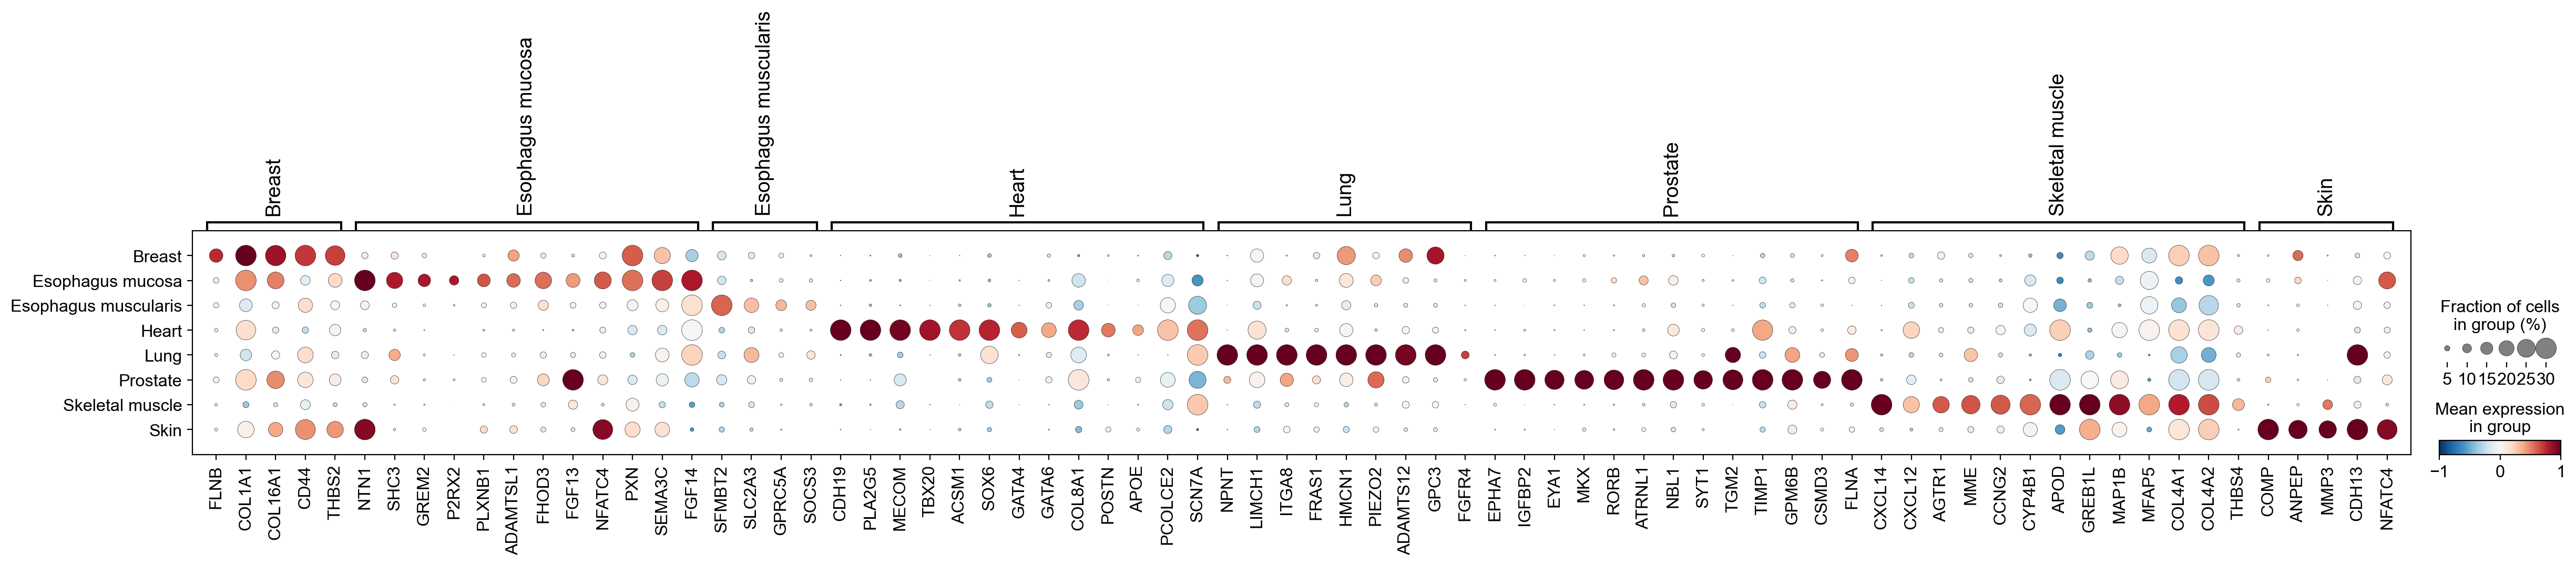

In [1133]:
sc.pl.dotplot(fib, final_markers, 'Tissue', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r', dot_max=.3)

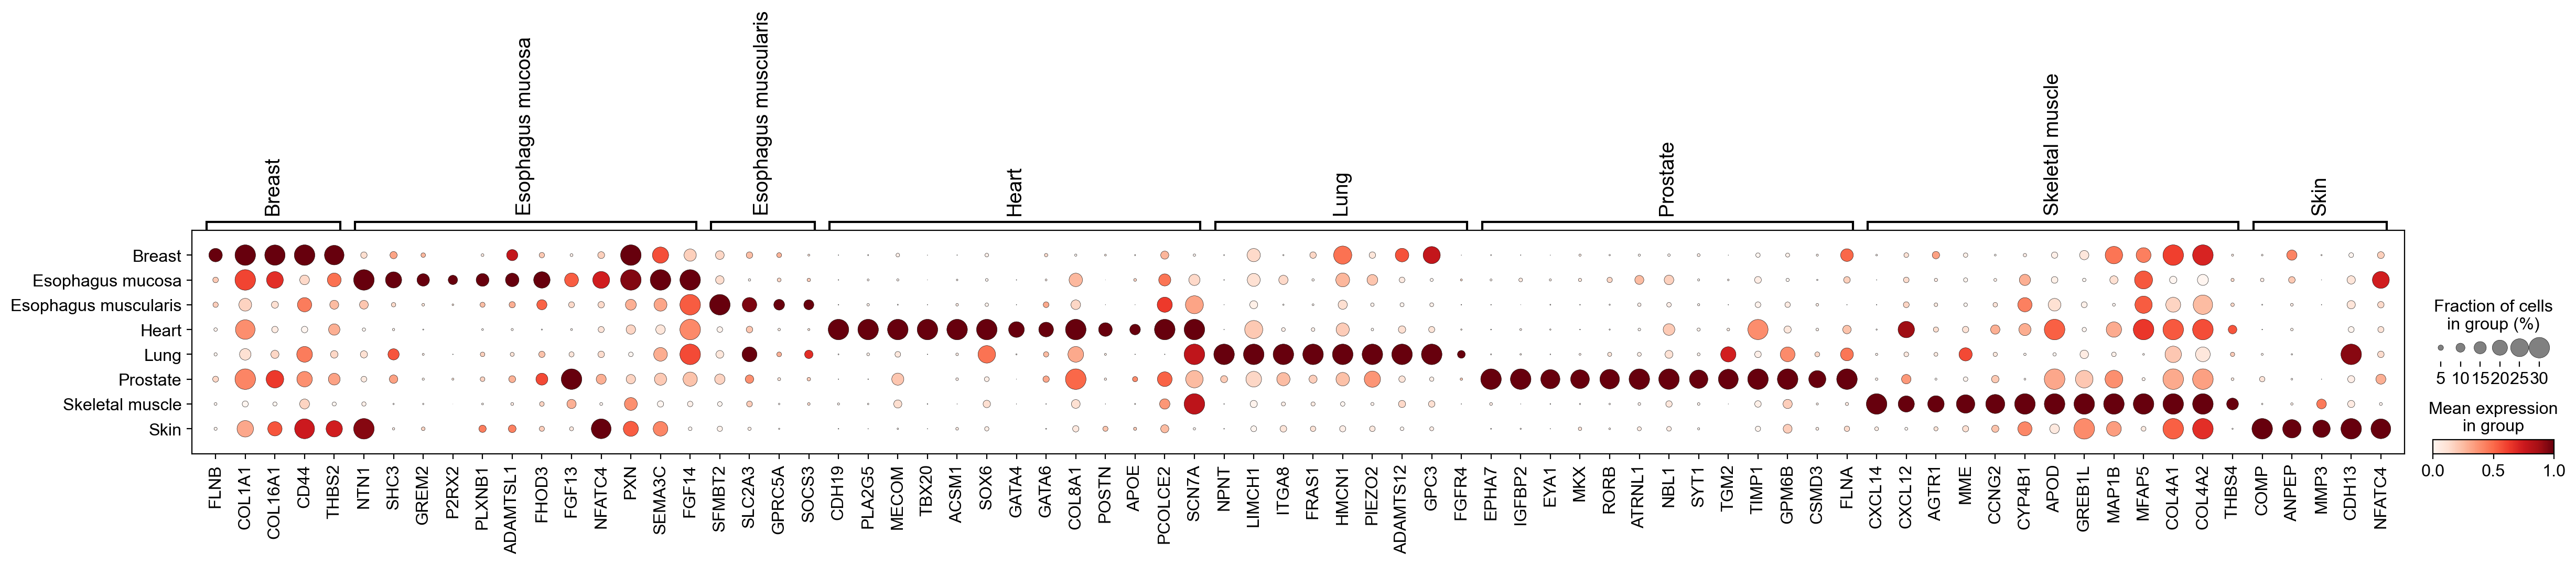

In [1134]:
sc.pl.dotplot(fib, final_markers, 'Tissue', cmap='Reds', standard_scale='var', dot_max=.3)

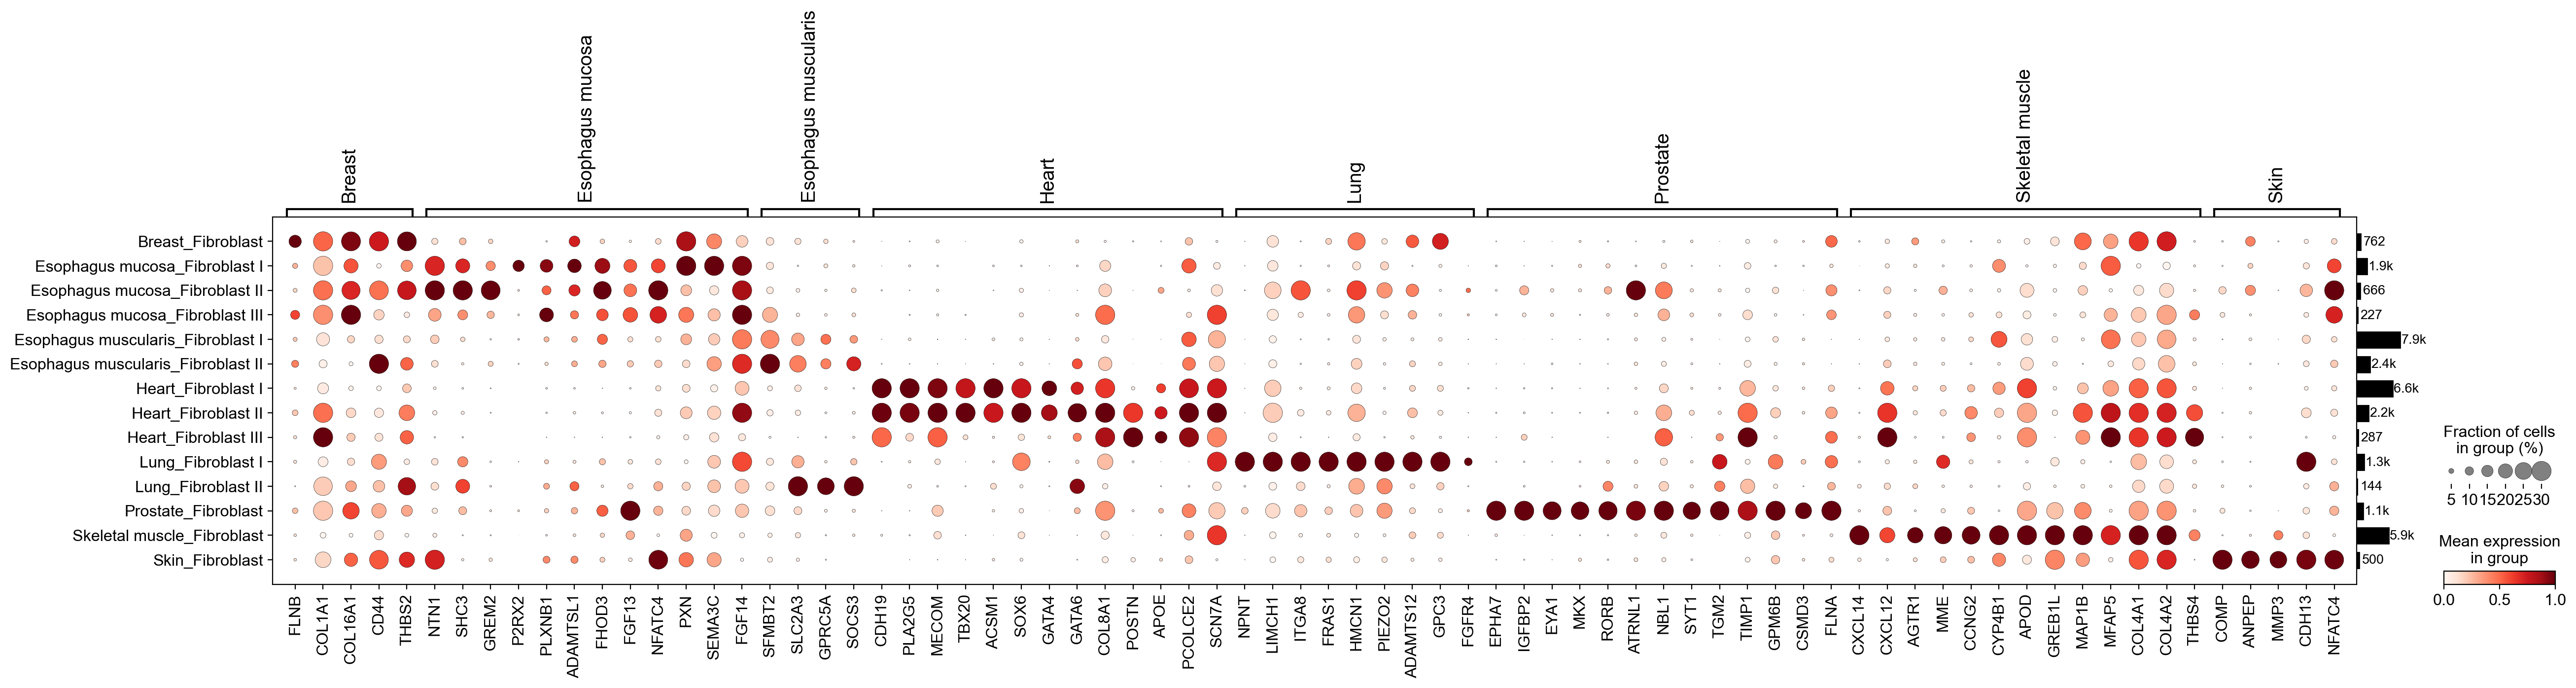

In [1656]:
g = sc.pl.dotplot(fib[fib.obs['Granular cell type'].str.startswith('Fibroblast')], final_markers, ['Tissue', 'Granular cell type'], cmap='Reds', standard_scale='var', dot_max=.3, return_fig=True)

g.add_totals(color='black')
g.show()

g

## Interactions

In [1676]:
int_markers = ['NTN1', 'UNC5A', 'UNC5C', 'DCC', 'PLXNB1', 'SEMA4D', 'SEMA4A']

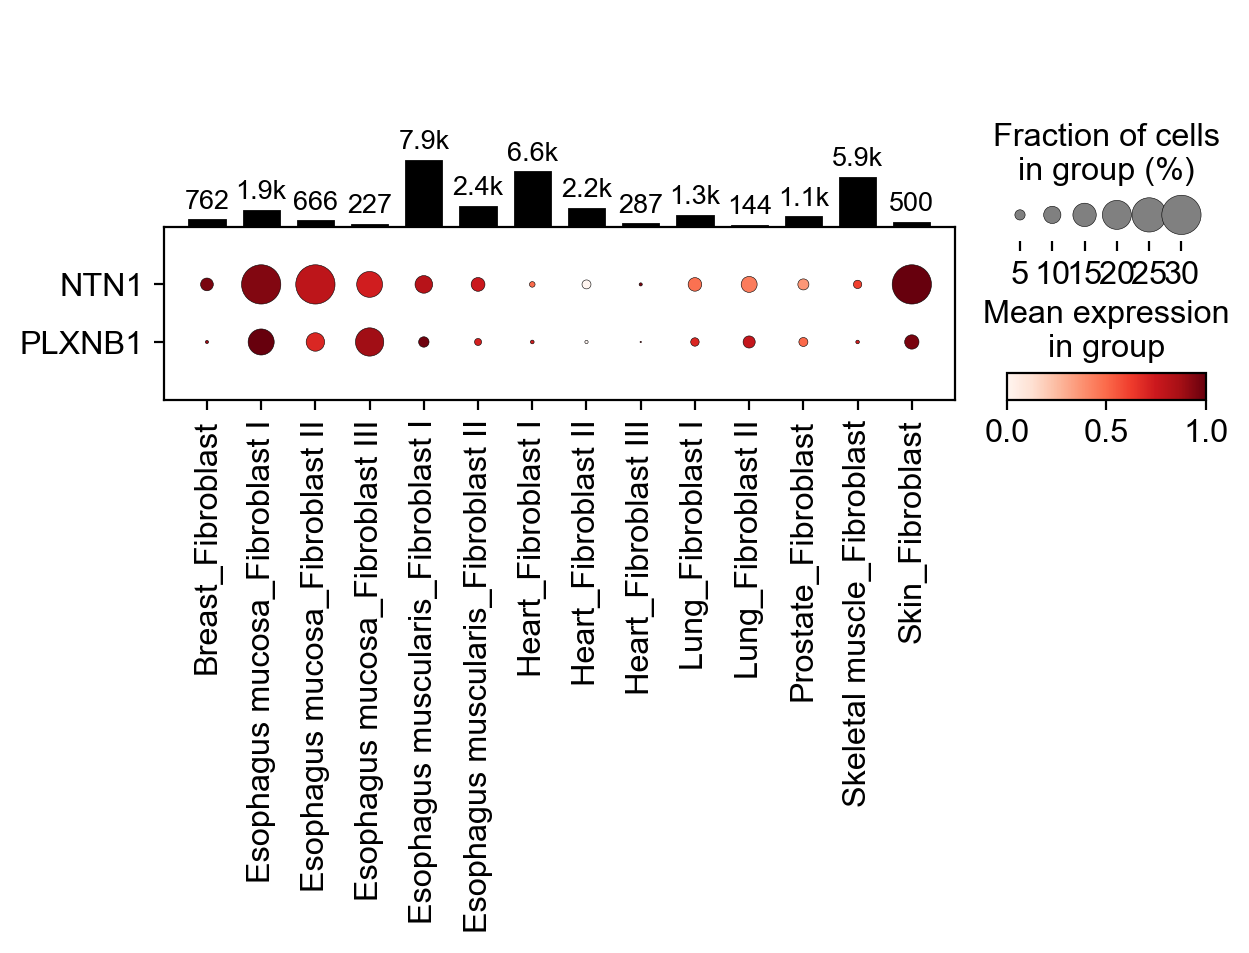

In [1701]:
g = sc.pl.dotplot(fib[fib.obs['Granular cell type'].str.startswith('Fibroblast') ],
                  ['NTN1', 'PLXNB1'],
                  ['Tissue', 'Granular cell type'], cmap='Reds', standard_scale='var', dot_max=.3, return_fig=True, mean_only_expressed=True, swap_axes=True)

g.add_totals(color='black')
g.savefig('figures/Figure-S18-E-left.pdf')
g

In [1691]:
musc = adata[adata.obs.Tissue == 'Esophagus muscularis'].copy()
musc.layers['scaled'] = musc.X.copy()
sc.pp.scale(musc, layer='scaled')

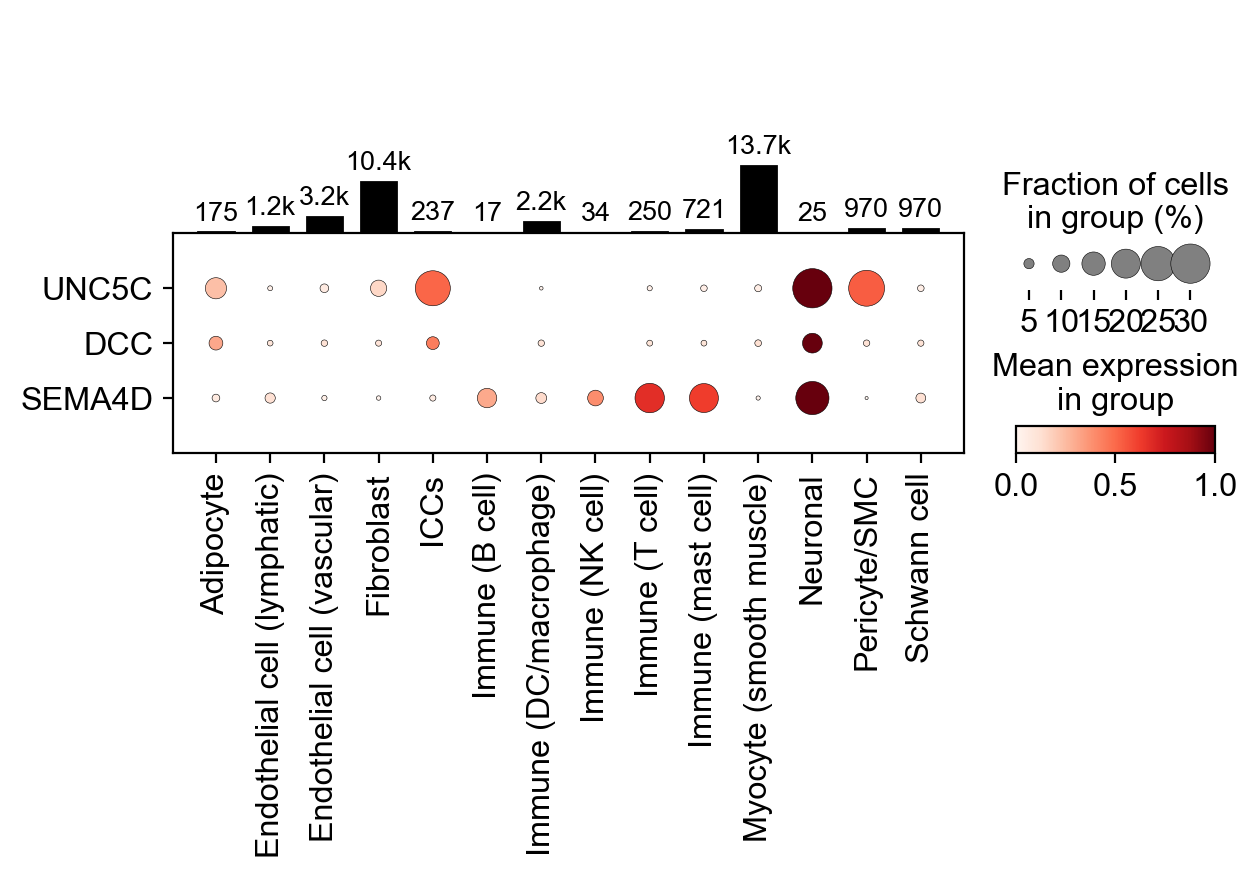

In [1700]:
g = sc.pl.dotplot(musc,
                  ['UNC5C', 'DCC', 'SEMA4D'],
                  ['Broad cell type'], cmap='Reds', standard_scale='var', dot_max=.3, return_fig=True, swap_axes=True)
g.add_totals(color='black')
g.savefig('figures/Figure-S18-E-right.pdf')
g

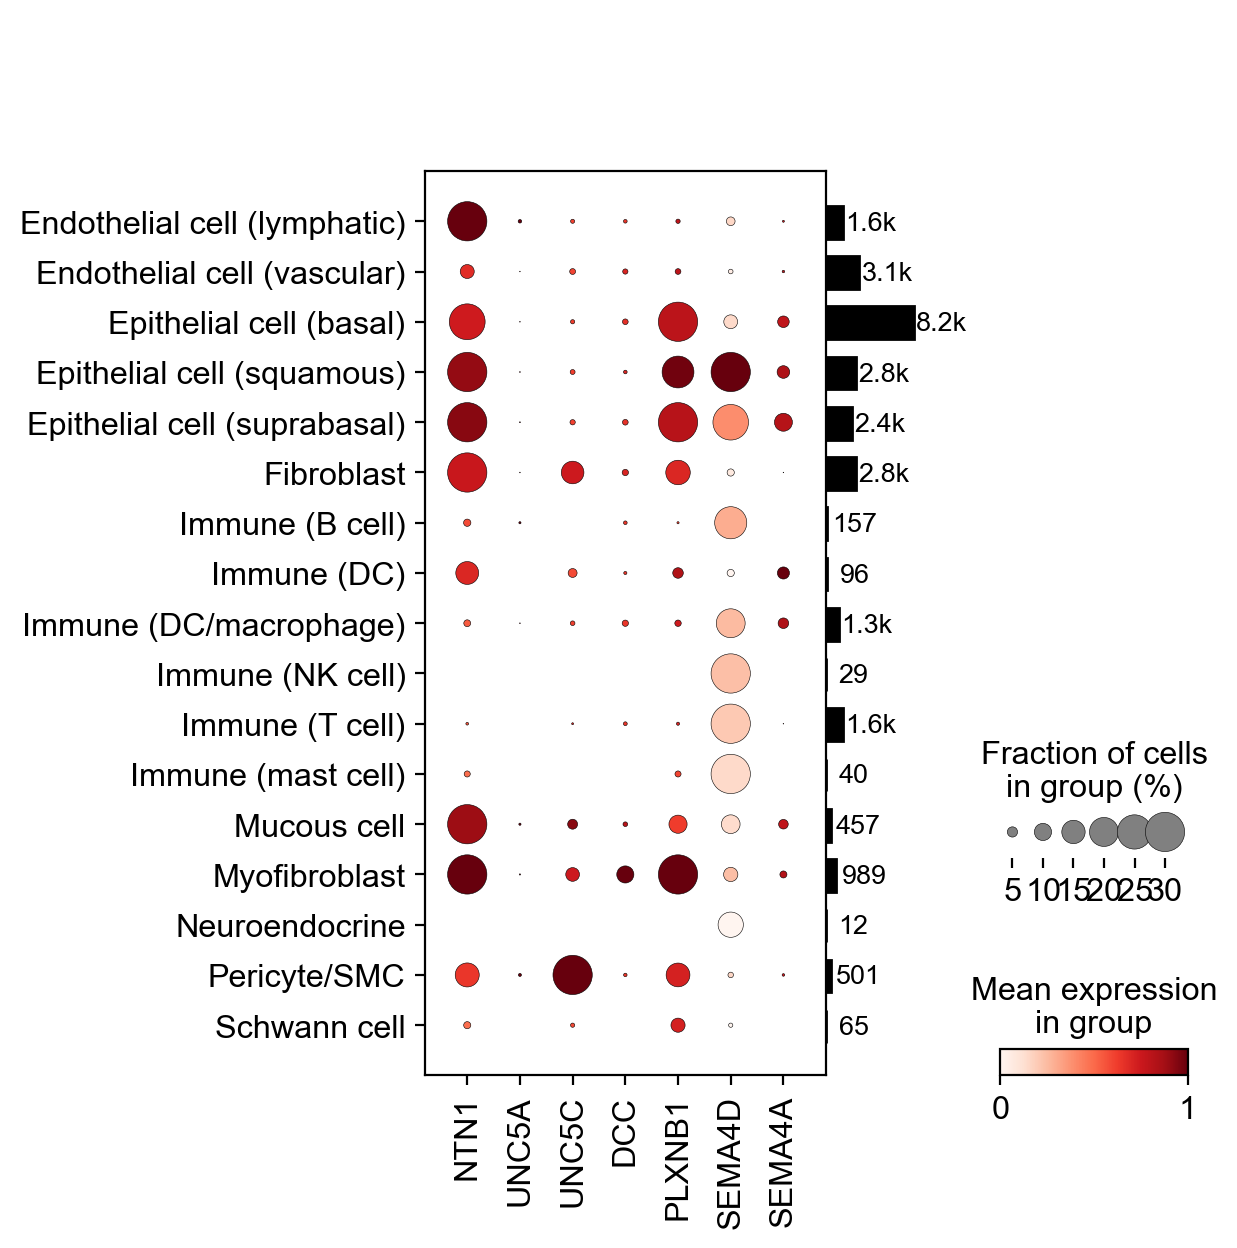

In [1687]:
g = sc.pl.dotplot(adata[adata.obs.Tissue == 'Esophagus mucosa'],
                  int_markers,
                  ['Broad cell type'], cmap='Reds', standard_scale='var', dot_max=.3, return_fig=True, mean_only_expressed=True)

g.add_totals(color='black')
g.show()

g

## Travaglini marker scoring

In [1559]:
fibro_de = pd.read_pickle('../sc-sn-integration/sc_sn_merged_data/fibro_markers_krasnow.pkl')
fibro_de

group         names     scores  logfoldchanges  \
0    Adventitial Fibroblast      SERPINF1  30.514193        3.030088   
1    Adventitial Fibroblast        CCDC80  29.982836        4.008088   
2    Adventitial Fibroblast            C3  27.573059        3.351515   
3    Adventitial Fibroblast        IGFBP6  25.432768        3.813002   
4    Adventitial Fibroblast         GPNMB  22.770489        3.416428   
..                      ...           ...        ...             ...   
379           Myofibroblast        ATP10A   3.560330        3.072090   
380           Myofibroblast         PARM1   3.544958        3.101157   
381           Myofibroblast        GABRB2   3.541692        3.452178   
382           Myofibroblast  LOC102724094   3.488890        3.150448   
383           Myofibroblast          EREG   3.457263        4.615652   

             pvals      pvals_adj  
0    1.124178e-141  1.590768e-137  
1    7.714917e-127  7.277996e-123  
2    3.567773e-117  2.524289e-113  
3    5.073604e-100   2.871761e-96  
4     2.958102e-85   8.371724e-82  
..             ...            ...  
379   4.415039e-04   6.392055e-03  
380   4.675598e-04   6.723786e-03  
381   4.731850e-04   6.790877e-03  
382   5.713949e-04   7.962111e-03  
383   6.413266e-04   8.862395e-03  

[384 rows x 6 columns]

In [1561]:
markers = fibro_de.groupby('group').names.agg(list).to_dict()

In [1562]:
for g in fibro_de['group'].unique():
    sc.tl.score_genes(fib, markers[g], score_name=g)

In [ ]:
sc.pl.violin(fib, list(markers.keys()), 'Tissue', rotation=90, stripplot=False, inner='box')

In [1724]:
plt.rcParams['figure.figsize'] = [5,4]

sc.pl.violin(lung, ['ITGA8', 'PIEZO2'], 'Granular cell type', rotation=90, stripplot=False, inner='box', use_raw=False, save='Figure-4H.pdf')

plt.rcParams['figure.figsize'] = [4,4]

In [1564]:
lungfib = lung[lung.obs['Granular cell type'].str.startswith('Fibro') & (lung.obs['Broad cell type'] == 'Fibroblast')].copy()

In [1568]:
lungfib.X = lungfib.layers['counts'].copy()
sc.pp.normalize_total(lungfib, target_sum=10000)
sc.pp.log1p(lungfib)

sc.pp.highly_variable_genes(lungfib, n_top_genes=1000)
sc.pp.pca(lungfib)
lungfib.obsm['X_harmony'] = harmonize(lungfib.obsm['X_pca'], lungfib.obs, 'Participant ID')
sc.pp.neighbors(lungfib, use_rep='X_harmony')
sc.tl.umap(lungfib)

lungfib.layers['scaled'] = lungfib.X.copy()
sc.pp.scale(lungfib, max_value=10, layer='scaled')

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


In [1599]:
import scipy as sp

In [1628]:
for g in fibro_de['group'].unique():
    sc.tl.score_genes(lungfib, markers[g], score_name=f'Travaglini et al. {g.lower()}')
    lungfib.obs[f'Travaglini et al. {g.lower()}'] = sp.stats.zscore(lungfib.obs[f'Travaglini et al. {g.lower()}'])
    
sc.tl.score_genes(lungfib, turley_human['Lung Alveolar'], score_name='Buechler et al. alveolar fibroblast')
lungfib.obs['Buechler et al. alveolar fibroblast'] = sp.stats.zscore(lungfib.obs['Buechler et al. alveolar fibroblast'])

In [1633]:
lungfib.obs['Granular cell type'].cat.rename_categories(['Fibroblast I (Alveolar)', 'Fibroblast II (Adventitial)'], inplace=True)

In [1743]:
%matplotlib inline

In [1748]:
sc.set_figure_params(dpi=100)

In [1704]:
go_gene_dict = {
    'ECM': ['NPNT', 'ITGA8', 'FRAS1', 'HMCN1', 'COL6A6', 'CCBE1', 'ADAMTS8', 'COL21A1', 'GPC3', 'NTNG1', 'PTPRQ', 'EMID1'],
    'Cation transport': ['PIEZO2', 'RYR2', 'CACNA1D', 'GRIA1', 'ADRA1A', 'SLC25A25', 'TRPC6', 'PRKCB', 'MCOLN2', 'CDH23', 'P2RY12', 'KCNK6', 'MAOB', 'SNAP25', 'SLC40A1'],
    'Contractile actin filament': ['MYLK', 'MYO10', 'NEBL', 'LIMCH1'],
}
sc.pl.dotplot(fib[fib.obs['Granular cell type'].str.startswith('Fibroblast')], go_gene_dict, ['Tissue', 'Granular cell type'], cmap='RdBu_r', layer='scaled', vmin=-1, vmax=1, dot_max=.3, save='figure-4F.pdf')

In [ ]:
sc.pl.umap(lungfib, color=['GPC3', 'C3', 'Adventitial Fibroblast', 'Alveolar Fibroblast', 'Granular cell type'], cmap='RdBu_r', frameon=False, use_raw=False, vmin=-2, vmax=2, ncols=5, layer='scaled')

In [1581]:
sc.tl.rank_genes_groups(lungfib, 'Granular cell type', use_raw=False)

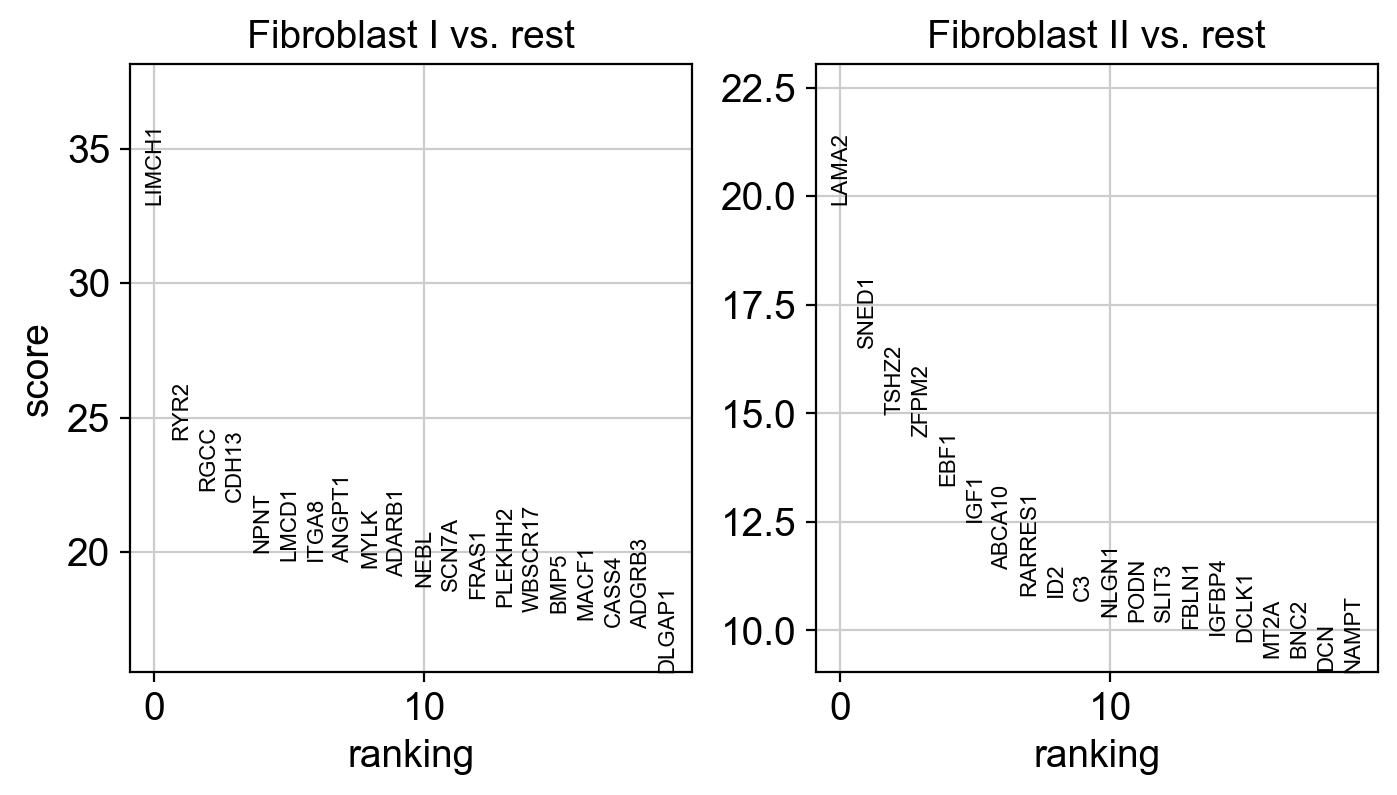

In [1583]:
sc.pl.rank_genes_groups(lungfib, sharey=False)

In [1549]:
lungfib.obs['Granular cell type'].value_counts()

Fibroblast I     1318
Fibroblast II     144
Name: Granular cell type, dtype: int64

## Diseases linked to markers

In [1244]:
omim[[np.any(np.isin(final_markers_flat, x)) for x in omim.genes]].sort_values('genes')

/home/gokcen/.miniconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


title  \
104310                                                       ALZHEIMER DISEASE 2; AD2   
269600                                                    SEA-BLUE HISTIOCYTE DISEASE   
611771                                                LIPOPROTEIN GLOMERULOPATHY; LPG   
617347                                                 HYPERLIPOPROTEINEMIA, TYPE III   
609027                                                 BLOOD GROUP, INDIAN SYSTEM; IN   
603932                                               INTERVERTEBRAL DISC DISEASE; IDD   
114000                                                          CAFFEY DISEASE; CAFYD   
130060                       EHLERS-DANLOS SYNDROME, ARTHROCHALASIA TYPE, 1; EDSARTH1   
619115          COMBINED OSTEOGENESIS IMPERFECTA AND EHLERS-DANLOS SYNDROME 1; OIEDS1   
166200                                           OSTEOGENESIS IMPERFECTA, TYPE I; OI1   
166210                                          OSTEOGENESIS IMPERFECTA, TYPE II; OI2   
166220                                          OSTEOGENESIS IMPERFECTA, TYPE IV; OI4   
259420                                         OSTEOGENESIS IMPERFECTA, TYPE III; OI3   
611773  ANGIOPATHY, HEREDITARY, WITH NEPHROPATHY, ANEURYSMS, AND MUSCLE CRAMPS; HANAC   
175780           BRAIN SMALL VESSEL DISEASE 1 WITH OR WITHOUT OCULAR ANOMALIES; BSVD1   
618564   MICROANGIOPATHY AND LEUKOENCEPHALOPATHY, PONTINE, AUTOSOMAL DOMINANT; PADMAL   
180000                                         RETINAL ARTERIES, TORTUOSITY OF; RATOR   
614519                              HEMORRHAGE, INTRACEREBRAL, SUSCEPTIBILITY TO; ICH   
614483                                            BRAIN SMALL VESSEL DISEASE 2; BSVD2   
619161                                                 CARPAL TUNNEL SYNDROME 2; CTS2   
132400                                        EPIPHYSEAL DYSPLASIA, MULTIPLE, 1; EDM1   
177170                                                    PSEUDOACHONDROPLASIA; PSACH   
145500                                                        HYPERTENSION, ESSENTIAL   
113650                                              BRANCHIOOTORENAL SYNDROME 1; BOR1   
166780                                             OTOFACIOCERVICAL SYNDROME 1; OTFCS   
602588                                                  BRANCHIOOTIC SYNDROME 1; BOS1   
301058                           DEVELOPMENTAL AND EPILEPTIC ENCEPHALOPATHY 90; DEE90   
609307                                               SPINOCEREBELLAR ATAXIA 27; SCA27   
314400                                     CARDIAC VALVULAR DYSPLASIA, X-LINKED; CVD1   
309350                                                  MELNICK-NEEDLES SYNDROME; MNS   
305620                                            FRONTOMETAPHYSEAL DYSPLASIA 1; FMD1   
304120                                       OTOPALATODIGITAL SYNDROME, TYPE II; OPD2   
300321                                                            FG SYNDROME 2; FGS2   
311300                                        OTOPALATODIGITAL SYNDROME, TYPE I; OPD1   
300049                                   PERIVENTRICULAR NODULAR HETEROTOPIA 1; PVNH1   
300244                                                TERMINAL OSSEOUS DYSPLASIA; TOD   
300048           INTESTINAL PSEUDOOBSTRUCTION, NEURONAL, CHRONIC IDIOPATHIC, X-LINKED   
272460                                   SPONDYLOCARPOTARSAL SYNOSTOSIS SYNDROME; SCT   
108721                                                ATELOSTEOGENESIS, TYPE III; AO3   
150250                                                           LARSEN SYNDROME; LRS   
108720                                                  ATELOSTEOGENESIS, TYPE I; AO1   
112310                                                     BOOMERANG DYSPLASIA; BOOMD   
219000                                                     FRASER SYNDROME 1; FRASRS1   
615542           TESTICULAR ANOMALIES WITH OR WITHOUT CONGENITAL HEART DISEASE; TACHD   
614429                                              VENTRICULAR SEPTAL DEFE

## Score Buechler et al. genes

In [1141]:
sc.tl.score_genes(fib, turley_human['Lung Alveolar'], score_name='Buechler et al. alveolar fibroblast signaure')
sc.pl.violin(fib, 'Buechler et al. Lung Alveolar signaure', 'Tissue', inner='box', stripplot=False, rotation=90, save='buechler_etal_alveolar_mac_signatures.pdf')

In [1142]:
sc.pl.dotplot(fib, turley_human, 'Tissue', standard_scale='var', dot_max=.3, save='buechler_etal_all_human_signatures.pdf')

In [ ]:
dotplot_spring(fib, 'Tissue', n_genes=30, layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r', dot_max=.3)

In [ ]:
dotplot_spring(fib, 'Tissue', n_genes=20, vmax=4, vmin=0, dot_max=.3, mean_only_expressed=True)

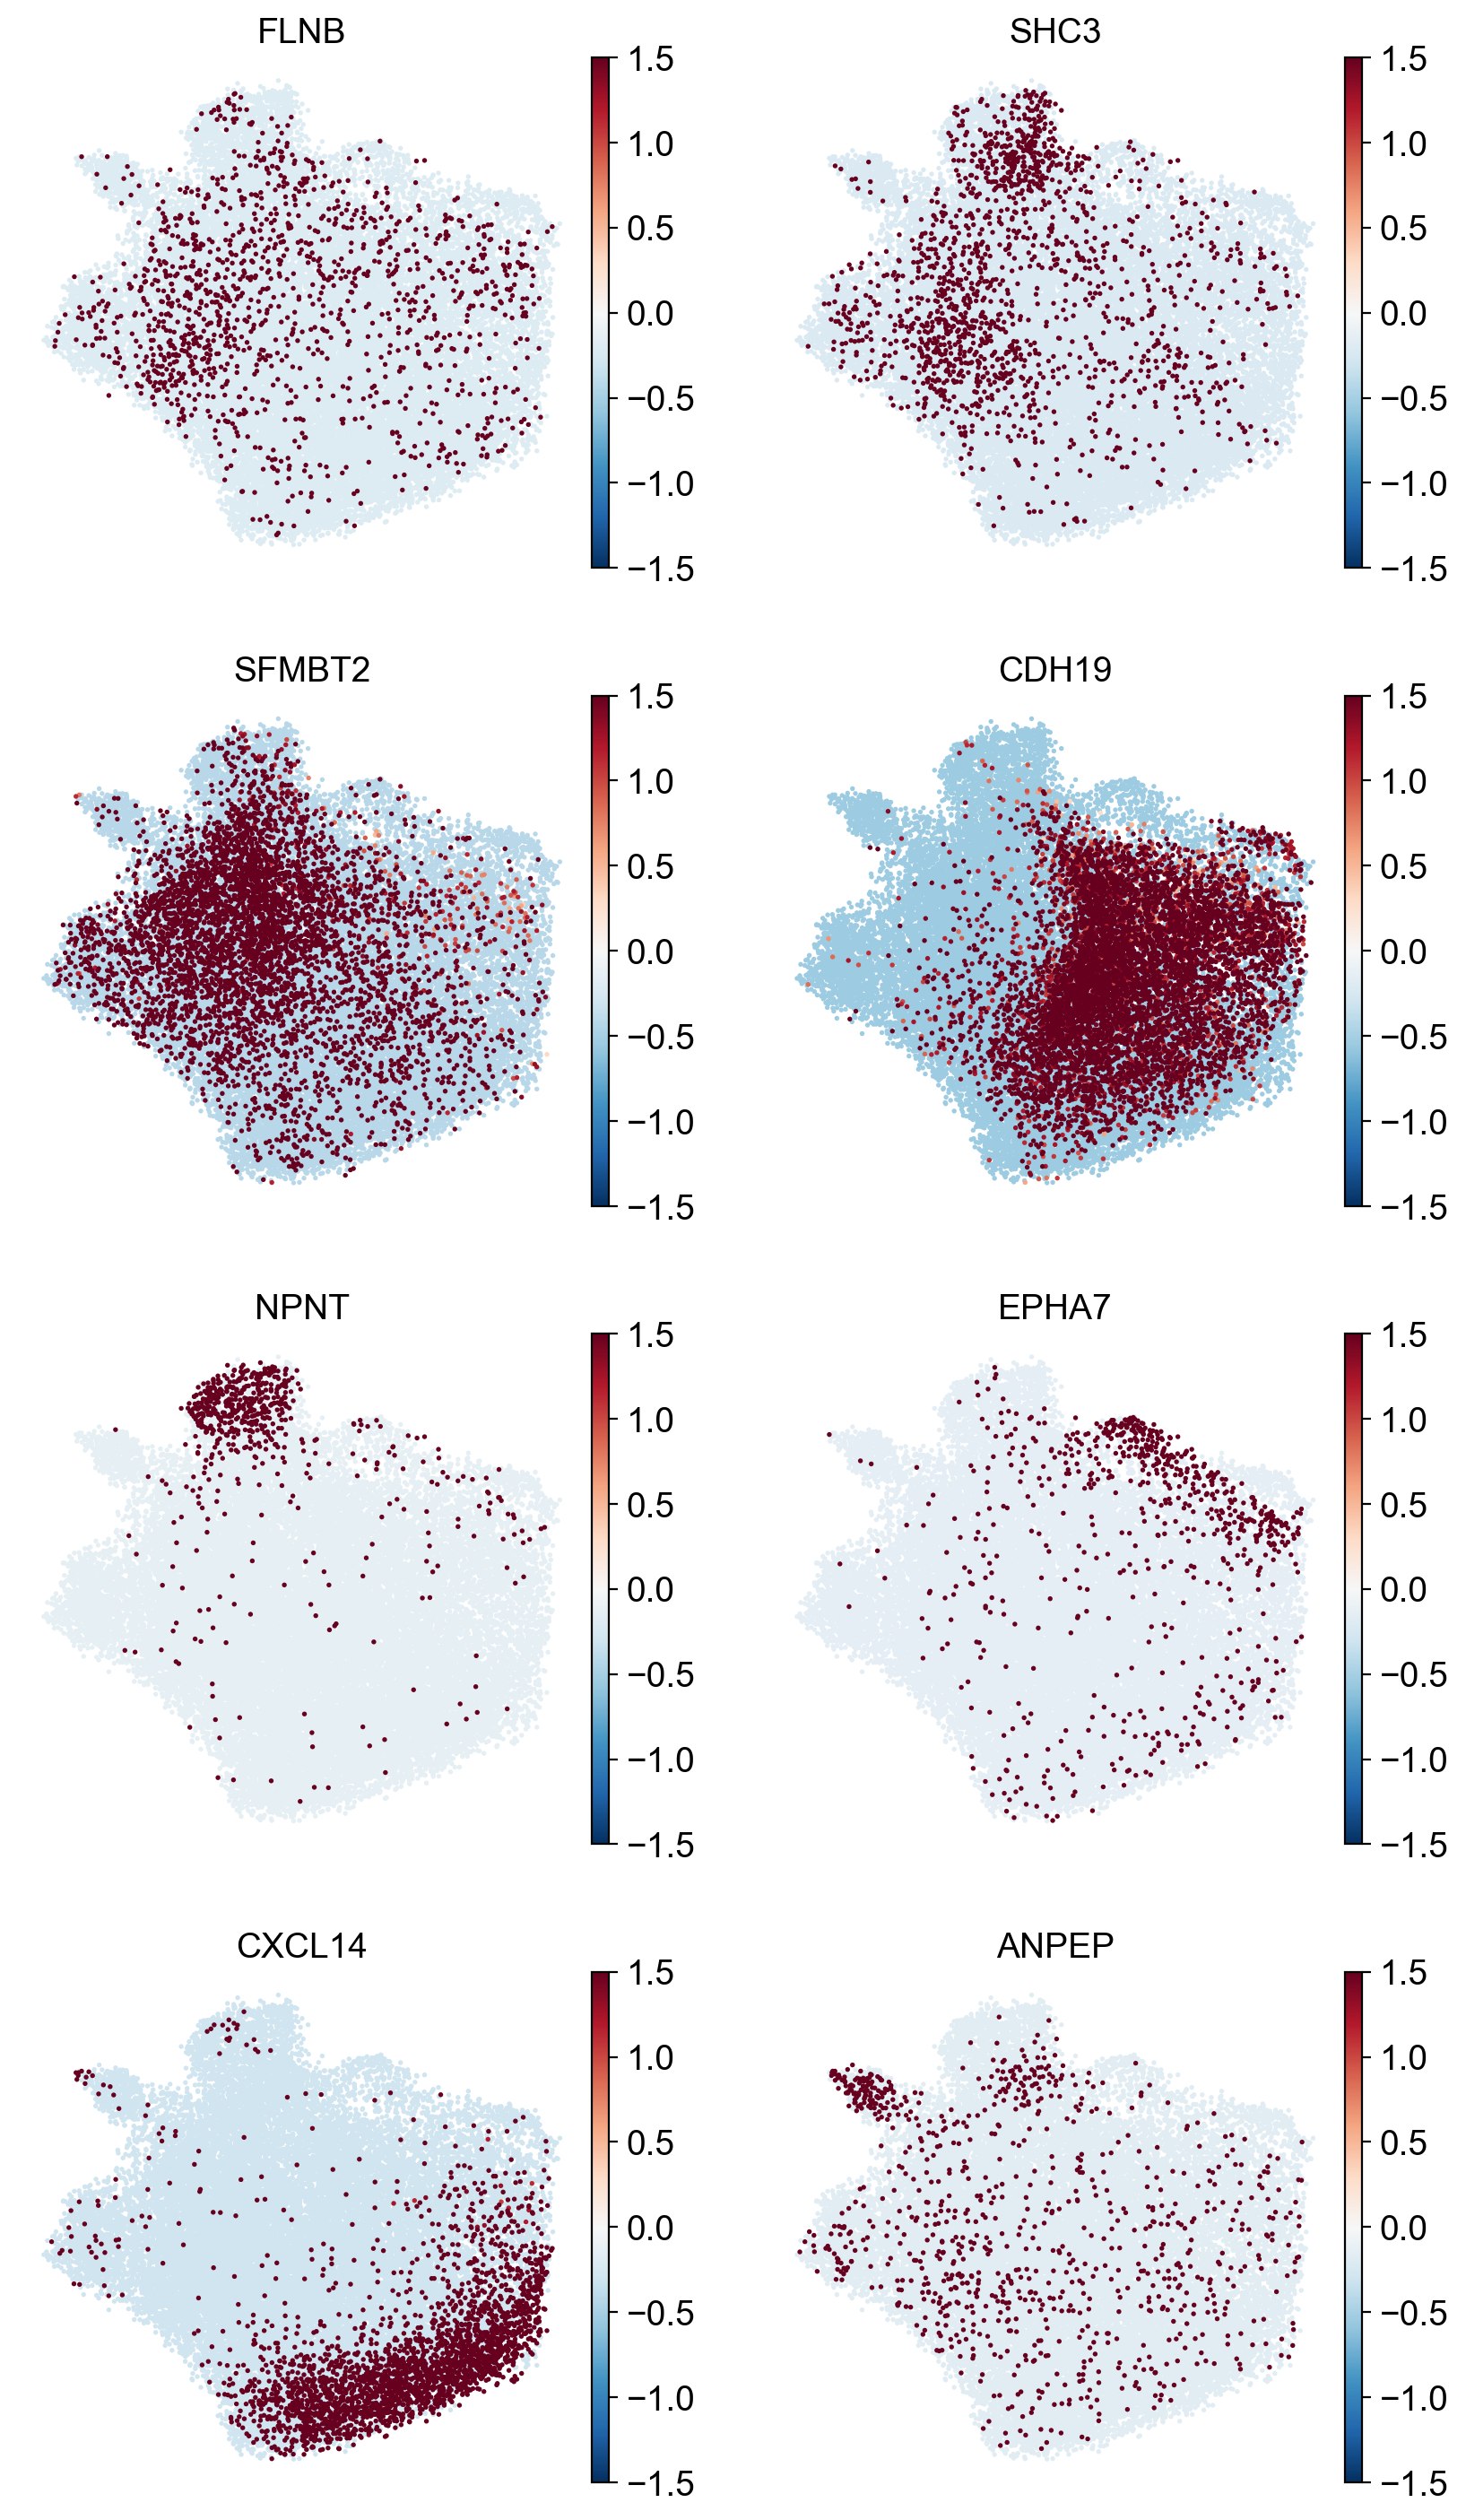

In [946]:
sc.pl.umap(fib, color=['FLNB', 'SHC3', 'SFMBT2', 'CDH19', 'NPNT', 'EPHA7', 'CXCL14', 'ANPEP'], legend_loc='on data', legend_fontoutline=2, cmap='RdBu_r', vmax=1.5, vmin=-1.5, layer='scaled', size=15, ncols=2, frameon=False, save='-fibroblast-xtissue-D-markerumap.pdf')

## Modules

In [1709]:
def gwas_enrichment(adata, gwas_ad, obs_key=None):

    background = sorted(set(gwas_ad.var_names) | set(adata.var_names))

    print('Building expression module df...')
    module_dict = {}
    for l in tqdm(adata.uns['paris']['module_dict'].keys()):
        mod_dict = adata.uns['paris']['module_dict'][l]
        fisher_df = pd.DataFrame(dict(background=background))
        for mod, genes in mod_dict.items():
            fisher_df[mod] = fisher_df.background.isin(genes)

        module_dict[l] = fisher_df.set_index('background')

    module_df = pd.concat(module_dict.values(), axis=1, keys=module_dict.keys()).T

    gwas_df = pd.DataFrame(gwas_ad.X.astype(bool).A, index=gwas_ad.obs_names, columns=gwas_ad.var_names).T
    gwas_df.columns.name = None

    background_df = pd.DataFrame(index=background)
    gwas_df = gwas_df.join(background_df, how='outer').fillna(False).T

    print('Calculating binary test statistics...')
    final_df = binary_test_statistics(gwas_df, module_df)
    
    if obs_key is not None:
        if 'score_tags' not in adata.uns['paris']:
            print('Scoring modules and merging score info...')
            tag_with_score(adata, obs_key, zcutoff=0)
        
        final_df = final_df.reset_index().merge(adata.uns['paris']['score_tags'])
    
    return final_df

In [1710]:
def binary_test_statistics(gwas_df, module_df):
    assert np.all(gwas_df.columns == module_df.columns), 'Columns of dfs must match'

    from fisher import pvalue_npy
    import sparse
    
    x = sparse.COO(gwas_df.values.astype('uint32'))
    y = sparse.COO(module_df.values.T.astype('uint32'))

    # find 2x2 values
    a = x.dot(y).todense()
    b = x.dot(1-(y.todense()))
    c = sparse.dot(1-(x.todense()), y)
    d = gwas_df.shape[1] - (a+b+c)

    # get intersections, phew
    nnz = (x.T[:, :, None] * y[:, None, :]).nonzero()
    nnz = pd.DataFrame(np.array(nnz).T, columns=['gene', 'gwas', 'module'])

    nnz['gene'] = gwas_df.columns[nnz['gene'].values]
    nnz['gwas'] = gwas_df.index[nnz['gwas'].values]
    nnz['level'] = [x[0] for x in module_df.index[nnz['module'].values]]
    nnz['module'] = [x[1] for x in module_df.index[nnz['module'].values]]

    nnz = nnz.groupby(['gwas', 'level', 'module'], observed=True)[['gene']].agg(tuple)

    # run fisher test
    pval = pvalue_npy(a.ravel().astype('uint'), 
                      b.ravel().astype('uint'), 
                      c.ravel().astype('uint'), 
                      d.ravel().astype('uint'))[1]
    pval = pval.reshape(a.shape)

    # calculate log odds, prec, recall, fscore
    with np.errstate(invalid='ignore', divide='ignore'):
        logodds = np.log2((a.astype(float)*d.astype(float)) / (b.astype(float)*c.astype(float)))
        
    precision = a/(a+c)    
    recall = a/(a+b)
    fscore = 2*precision*recall/(precision+recall)        
        
    # store everything in a data frame
    def melt(mat, valname):
        mat = pd.DataFrame(mat, index=gwas_df.index, columns=module_df.index).reset_index().rename(columns={'index': 'gwas'})
        mat = mat.melt(id_vars=['gwas'], var_name=['level', 'module'], value_name=valname).set_index(['gwas', 'level', 'module'])
        return mat

    pval = melt(pval, 'pval')
    logodds = melt(logodds, 'logodds')
    
    a = melt(a, 'pospos')
    b = melt(b, 'posneg')
    c = melt(c, 'negpos')
    d = melt(d, 'negneg')
    
    precision = melt(precision, 'precision')
    recall = melt(recall, 'recall')
    fscore = melt(fscore, 'fscore')    
    
    final_df = pval.copy()
    final_df['logOR'] = logodds.logodds
    final_df['pospos'] = a.pospos
    final_df['posneg'] = b.posneg
    final_df['negpos'] = c.negpos
    final_df['negneg'] = d.negneg

    final_df['precision'] = precision.precision
    final_df['recall'] = recall.recall
    final_df['fscore'] = fscore.fscore
    
    final_df['intersections'] = nnz.gene    
    
    final_df = final_df[(final_df.pospos>0)]
    
    return final_df

In [1790]:
final_markers

{'Breast': ['FLNB', 'COL1A1', 'COL16A1', 'CD44', 'THBS2'],
 'Esophagus mucosa': ['NTN1',
  'SHC3',
  'GREM2',
  'P2RX2',
  'PLXNB1',
  'ADAMTSL1',
  'FHOD3',
  'FGF13',
  'NFATC4',
  'PXN',
  'SEMA3C',
  'FGF14'],
 'Esophagus muscularis': ['SFMBT2', 'SLC2A3', 'GPRC5A', 'SOCS3'],
 'Heart': ['CDH19',
  'PLA2G5',
  'MECOM',
  'TBX20',
  'ACSM1',
  'SOX6',
  'GATA4',
  'GATA6',
  'COL8A1',
  'POSTN',
  'APOE',
  'PCOLCE2',
  'SCN7A'],
 'Lung': ['NPNT',
  'LIMCH1',
  'ITGA8',
  'FRAS1',
  'HMCN1',
  'PIEZO2',
  'ADAMTS12',
  'GPC3',
  'FGFR4'],
 'Prostate': ['EPHA7',
  'IGFBP2',
  'EYA1',
  'MKX',
  'RORB',
  'ATRNL1',
  'NBL1',
  'SYT1',
  'TGM2',
  'TIMP1',
  'GPM6B',
  'CSMD3',
  'FLNA'],
 'Skeletal muscle': ['CXCL14',
  'CXCL12',
  'AGTR1',
  'MME',
  'CCNG2',
  'CYP4B1',
  'APOD',
  'GREB1L',
  'MAP1B',
  'MFAP5',
  'COL4A1',
  'COL4A2',
  'THBS4'],
 'Skin': ['COMP', 'ANPEP', 'MMP3', 'CDH13', 'NFATC4']}

In [1711]:
cols = sorted(set(final_markers_flat))
gwas_ad = sc.AnnData(pd.DataFrame(np.vstack([np.array(np.isin(cols, markers)) for tissue,markers in final_markers.items()]), index=final_markers.keys(), columns=cols))
gwas_ad.X = sp.sparse.csr_matrix(gwas_ad.X)
gwas_ad

AnnData object with n_obs × n_vars = 8 × 73

In [ ]:
find_modules(fib)
#tag_with_score(fib, ['Tissue'], zcutoff=0., n_jobs=8)

In [1045]:
res = gwas_enrichment(fib, gwas_ad, 'Tissue')

Building expression module df...


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_360409/1792719800.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Calculating binary test statistics...


/tmp/ipykernel_360409/737047521.py:40: RuntimeWarning: invalid value encountered in true_divide


In [1271]:
res.sort_values('pval')[(res.gwas == 'Lung') & (res.category == 'Lung') & (res.pval<0.01)]

/tmp/ipykernel_360409/1070496756.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


gwas     level module          pval      logOR  pospos  posneg  negpos  \
288   Lung   level_3     44  6.392362e-12   8.293800       6       3     112   
99    Lung   level_1     35  2.874384e-11   7.918534       6       3     145   
622   Lung  level_13    347  8.982996e-11   8.449820       5       4      63   
540   Lung   level_9    201  2.817603e-10   8.103780       5       4      80   
1052  Lung  level_81    483  1.394356e-07   8.860842       3       6      19   
957   Lung  level_56    467  2.645002e-07   8.523399       3       6      24   
921   Lung  level_50    462  9.605264e-07   7.859290       3       6      38   
763   Lung  level_26    428  1.458833e-06   7.647295       3       6      44   
1108  Lung  level_99   2831  2.297800e-06  10.717758       2       7       3   
1038  Lung  level_75   3125  1.261791e-05   9.132306       2       7       9   
861   Lung  level_39   1720  2.406333e-05   8.601465       2       7      13   
1014  Lung  level_65   1476  2.406333e-05   8.601465       2       7      13   
761   Lung  level_26    410  4.805054e-05   8.053487       2       7      19   
775   Lung  level_28    546  7.426590e-05   7.716044       2       7      24   
624   Lung  level_13    448  1.204309e-04   7.346238       2       7      31   
547   Lung   level_9    398  2.456548e-04   6.807437       2       7      45   
384   Lung   level_4    280  4.704350e-04   6.320537       2       7      63   
259   Lung   level_2    166  1.001886e-03   5.756200       2       7      93   
900   Lung  level_47    432  2.033094e-03   9.525113       1       8       3   
131   Lung   level_1     53  2.157491e-03   5.183140       2       7     138   
850   Lung  level_37   1644  3.555502e-03   8.524868       1       8       6   
797   Lung  level_30    409  4.062512e-03   8.302394       1       8       7   
714   Lung  level_21    388  5.582168e-03   7.787576       1       8      10   

      negneg  precision    recall    fscore  \
288    17574   0.050847  0.666667  0.094488   
99     17541   0.039735  0.666667  0.075000   
622    17623   0.073529  0.555556  0.129870   
540    17606   0.058824  0.555556  0.106383   
1052   17667   0.136364  0.333333  0.193548   
957    17662   0.111111  0.333333  0.166667   
921    17648   0.073171  0.333333  0.120000   
763    17642   0.063830  0.333333  0.107143   
1108   17683   0.400000  0.222222  0.285714   
1038   17677   0.181818  0.222222  0.200000   
861    17673   0.133333  0.222222  0.166667   
1014   17673   0.133333  0.222222  0.166667   
761    17667   0.095238  0.222222  0.133333   
775    17662   0.076923  0.222222  0.114286   
624    17655   0.060606  0.222222  0.095238   
547    17641   0.042553  0.222222  0.071429   
384    17623   0.030769  0.222222  0.054054   
259    17593   0.021053  0.222222  0.038462   
900    17683   0.250000  0.111111  0.153846   
131    17548   0.014286  0.222222  0.026846   
850    17680   0.142857  0.111111  0.125000   
797    17679   0.125000  0.111111  0.117647   
714    17676   0.090909  0.111111  0.100000   

                                      intersections     key category  \
288   (ADAMTS12, FRAS1, GPC3, LIMCH1, NPNT, PIEZO2)  Tissue     Lung   
99    (ADAMTS12, FRAS1, GPC3, LIMCH1, NPNT, PIEZO2)  Tissue     Lung   
622             (FRAS1, GPC3, LIMCH1, NPNT, PIEZO2)  Tissue     Lung   
540             (FRAS1, GPC3, LIMCH1, NPNT, PIEZO2)  Tissue     Lung   
1052                           (GPC3, LIMCH1, NPNT)  Tissue     Lung   
957                            (GPC3, LIMCH1, NPNT)  Tissue     Lung   
921                            (GPC3, LIMCH1, NPNT)  Tissue     Lung   
763                            (GPC3, LIMCH1, NPNT)  Tissue     Lung   
1108                                 (FGFR4, ITGA8)  Tissue     Lung   
1038                                (FRAS1, PIEZO2)  Tissue     Lung   
861                                 (FRAS1, PIEZO2)  Tissue     Lung   
1014                                 (FGFR4, ITGA8)  Tissue     Lung   
761                 

In [1143]:
level = 13
module = 347
mod = sorted(fib.uns['paris']['module_dict'][f'level_{level}'][f'{module}'])

In [1282]:
len(set(mod))

68

In [1789]:
print('\n'.join(mod))

ADAM9
ADAMTS8
ADRA1A
ARHGAP28
C8orf4
CACNA1D
CCBE1
CDH23
COL21A1
COL6A6
DCC
DLGAP1
EMID1
FAT3
FRAS1
FRMD4B
GPC3
GRIA1
GRIK4
HIVEP3
HMCN1
INPP4B
KCNK6
L3MBTL4
LBH
LCLAT1
LIMCH1
LURAP1L
MAOB
MCOLN2
MEOX2
MYCL
MYLK
MYO10
NEBL
NPNT
NPTX1
NTNG1
NUAK1
P2RY12
PHACTR3
PIEZO2
PKIA
PKNOX2
PPP1R3C
PRDM6
PRKAA2
PRKCB
PTPRQ
RAPGEF5
RNF182
RSPO2
RYR2
SAMD5
SKAP2
SLC25A25
SLC40A1
SNAP25
SYTL2
TBX4
TMEM108
TMEM130
TMEM171
TMEM200A
TMEM74B
TPM4
TRPC6
UGT2B4


In [1216]:
gos = sc.queries.enrich(mod, gprofiler_kwargs={'no_evidences': False, 'sources':['GO:BP', 'HPA', 'KEGG', 'REAC', 'GO:CC']}).drop(columns=['evidences', 'parents', 'description'])
gos

source       native                                          name  \
0     HPA  HPA:0250142    hippocampus; neuronal projections[≥Medium]   
1     HPA  HPA:0250141       hippocampus; neuronal projections[≥Low]   
2   GO:CC   GO:0031012                          extracellular matrix   
3   GO:CC   GO:0030312              external encapsulating structure   
4   GO:BP   GO:0030001                           metal ion transport   
5   GO:BP   GO:0006812                              cation transport   
6   GO:BP   GO:0050804  modulation of chemical synaptic transmission   
7   GO:BP   GO:0099177        regulation of trans-synaptic signaling   
8   GO:BP   GO:0006816                         calcium ion transport   
9   GO:CC   GO:0034703                        cation channel complex   
10  GO:CC   GO:0062023      collagen-containing extracellular matrix   
11  GO:BP   GO:0006811                                 ion transport   
12   KEGG   KEGG:04724                         Glutamatergic synapse   
13    HPA  HPA:0250143       hippocampus; neuronal projections[High]   
14   KEGG   KEGG:05031                         Amphetamine addiction   
15  GO:CC   GO:0034702                           ion channel complex   
16   KEGG   KEGG:04020                     Calcium signaling pathway   
17   KEGG   KEGG:04921                    Oxytocin signaling pathway   
18  GO:CC   GO:0097517             contractile actin filament bundle   
19  GO:CC   GO:0001725                                  stress fiber   
20   KEGG   KEGG:04911                             Insulin secretion   
21   KEGG   KEGG:05410                   Hypertrophic cardiomyopathy   
22  GO:CC   GO:1902495             transmembrane transporter complex   
23  GO:CC   GO:0032432                         actin filament bundle   
24   KEGG   KEGG:04713                         Circadian entrainment   
25  GO:CC   GO:0042641                                    actomyosin   
26  GO:CC   GO:1990351                           transporter complex   

     p_value  significant  term_size  query_size  intersection_size  \
0   0.000177         True          7          36                  3   
1   0.000422         True          9          36                  3   
2   0.000967         True        562          66                 11   
3   0.000984         True        563          66                 11   
4   0.002184         True        523          61                 11   
5   0.003025         True       1210          61                 16   
6   0.003135         True        434          61                 10   
7   0.003201         True        435          61                 10   
8   0.003619         True        441          61                 10   
9   0.003854         True        227          66                  7   
10  0.004081         True        421          66                  9   
11  0.006406         True       1610          61                 18   
12  0.006769         True        114          33                  5   
13  0.009731         True          4          36                  2   
14  0.012518         True         69          33                  4   
15  0.023723         True        302          66                  7   
16  0.027371         True        239          33                  6   
17  0.027722         True        154          33                  5   
18  0.028997         True         70          66                  4   
19  0.028997         True         70          66                  4   
20  0.029271         True         86          33                  4   
21  0.034814         True         90          33                  4   
22  0.037431         True        325          66                  7   
23  0.044179         True         78          66                  4   
24  0.046259         True         97          33                  4   
25  0.046414         True         79          66                  4   
26  0.049419         True        340          66                  7  

In [1273]:
gos['neglog'] = -np.log10(gos.p_value+1e-30)
gos['pathway'] = [x[0].upper()+x[1:] for x in (gos.name.astype(str))]

<ggplot: (8759837750519)>

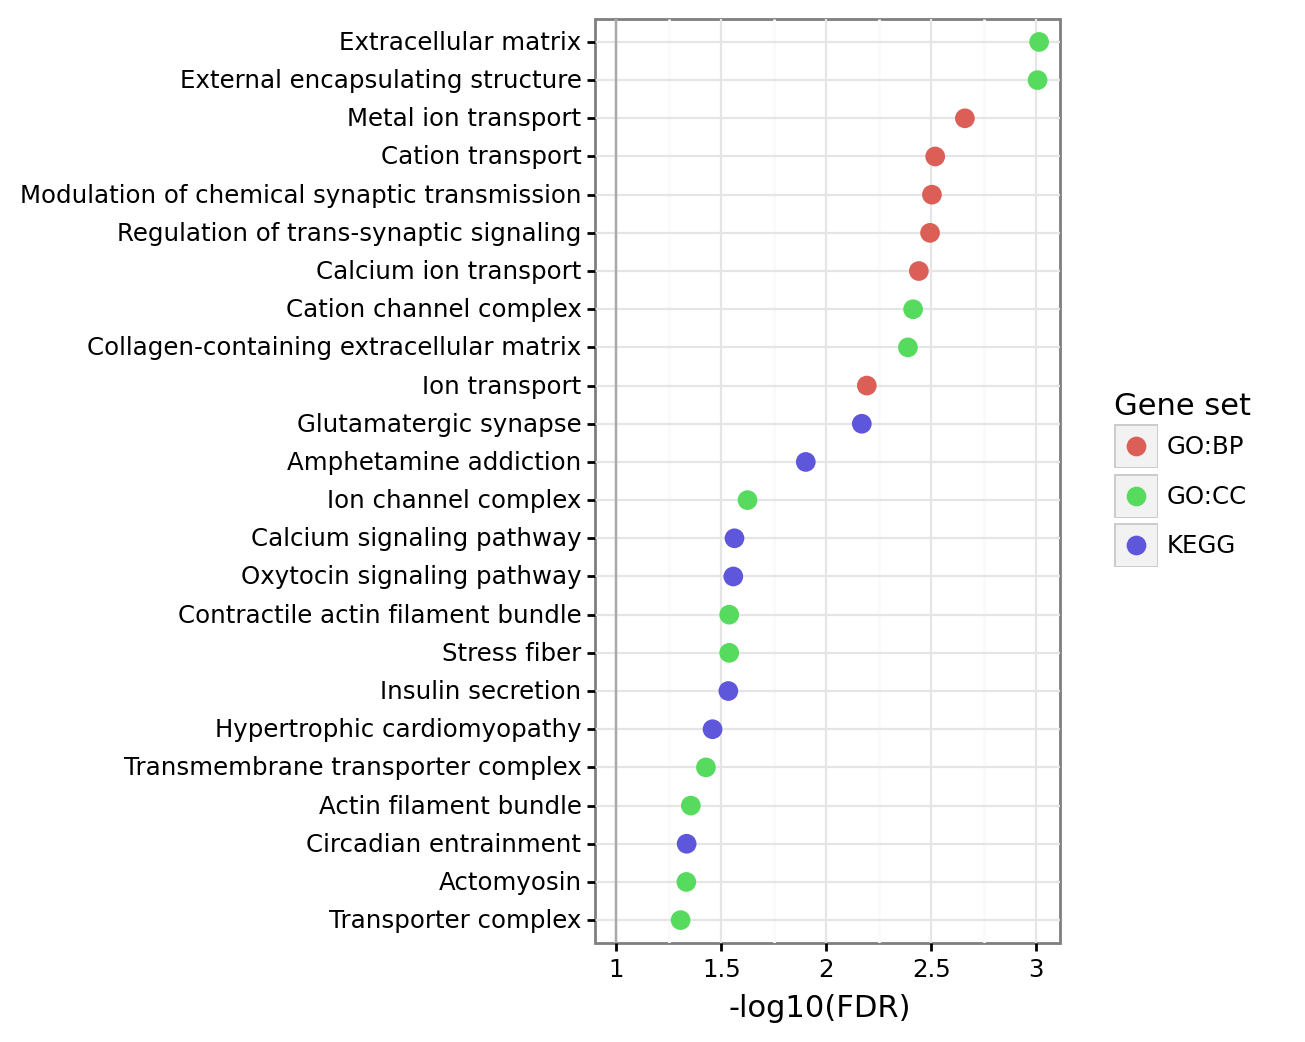

In [1281]:
from plotnine import * #LFC=1, pval=0.1, reac/go:bp

(
    ggplot(gos[gos.source != 'HPA']) + 
    geom_point(aes(y='reorder(pathway, neglog)', x='neglog', color='source'), size=3) + 
    geom_vline(xintercept=1, color='darkgray') +
    #facet_wrap('query', ncol=2, scales='free') +
    scale_y_discrete(drop=True, labels=lambda x: [i.split('|')[0] for i in x.keys()]) +
    theme_bw() +
    theme(figure_size=(3, 6), panel_spacing_y=0.4, panel_spacing_x=3.9, text=element_text(color='black')) +
    labs(x='-log10(FDR)', y='', color='Gene set')
)

In [1217]:
gos_genes = sorted(set([x for y in gos.intersections for x in y]))

In [1267]:
go_gene_dict = {
    'ECM': ['NPNT', 'ITGA8', 'FRAS1', 'HMCN1', 'COL6A6', 'CCBE1', 'ADAMTS8', 'COL21A1', 'GPC3', 'NTNG1', 'PTPRQ', 'EMID1'],
    'Cation transport': ['PIEZO2', 'RYR2', 'MYLK', 'CACNA1D', 'GRIA1', 'ADRA1A', 'SLC25A25', 'TRPC6', 'PRKCB', 'MCOLN2', 'CDH23', 'P2RY12', 'KCNK6', 'MAOB', 'SNAP25', 'SLC40A1'],
}

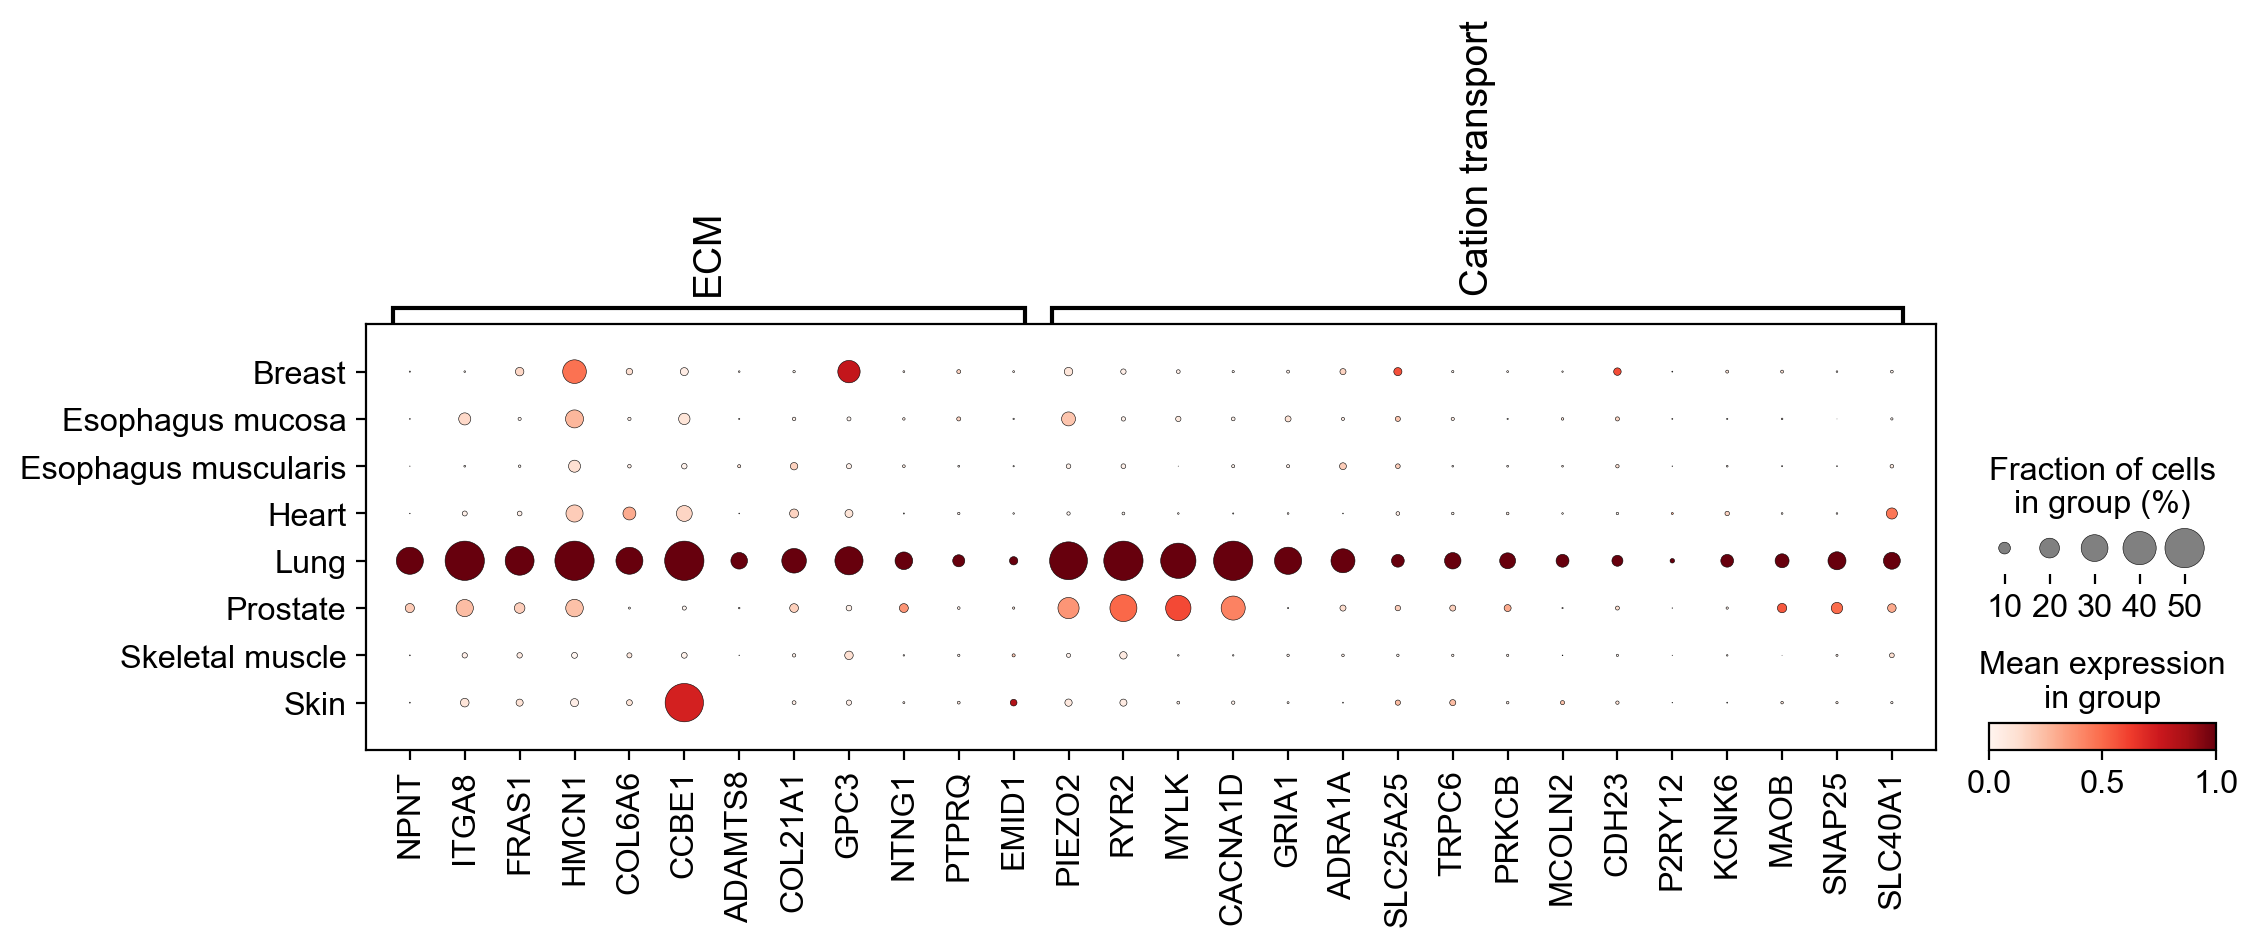

In [1268]:
sc.pl.dotplot(fib, go_gene_dict, 'Tissue', cmap='Reds', standard_scale='var', dot_max=.5)

categories: Endothelial cell (lymphatic), Endothelial cell (vascular), Epithelial cell (alveolar type I), etc.
var_group_labels: ECM, Cation transport


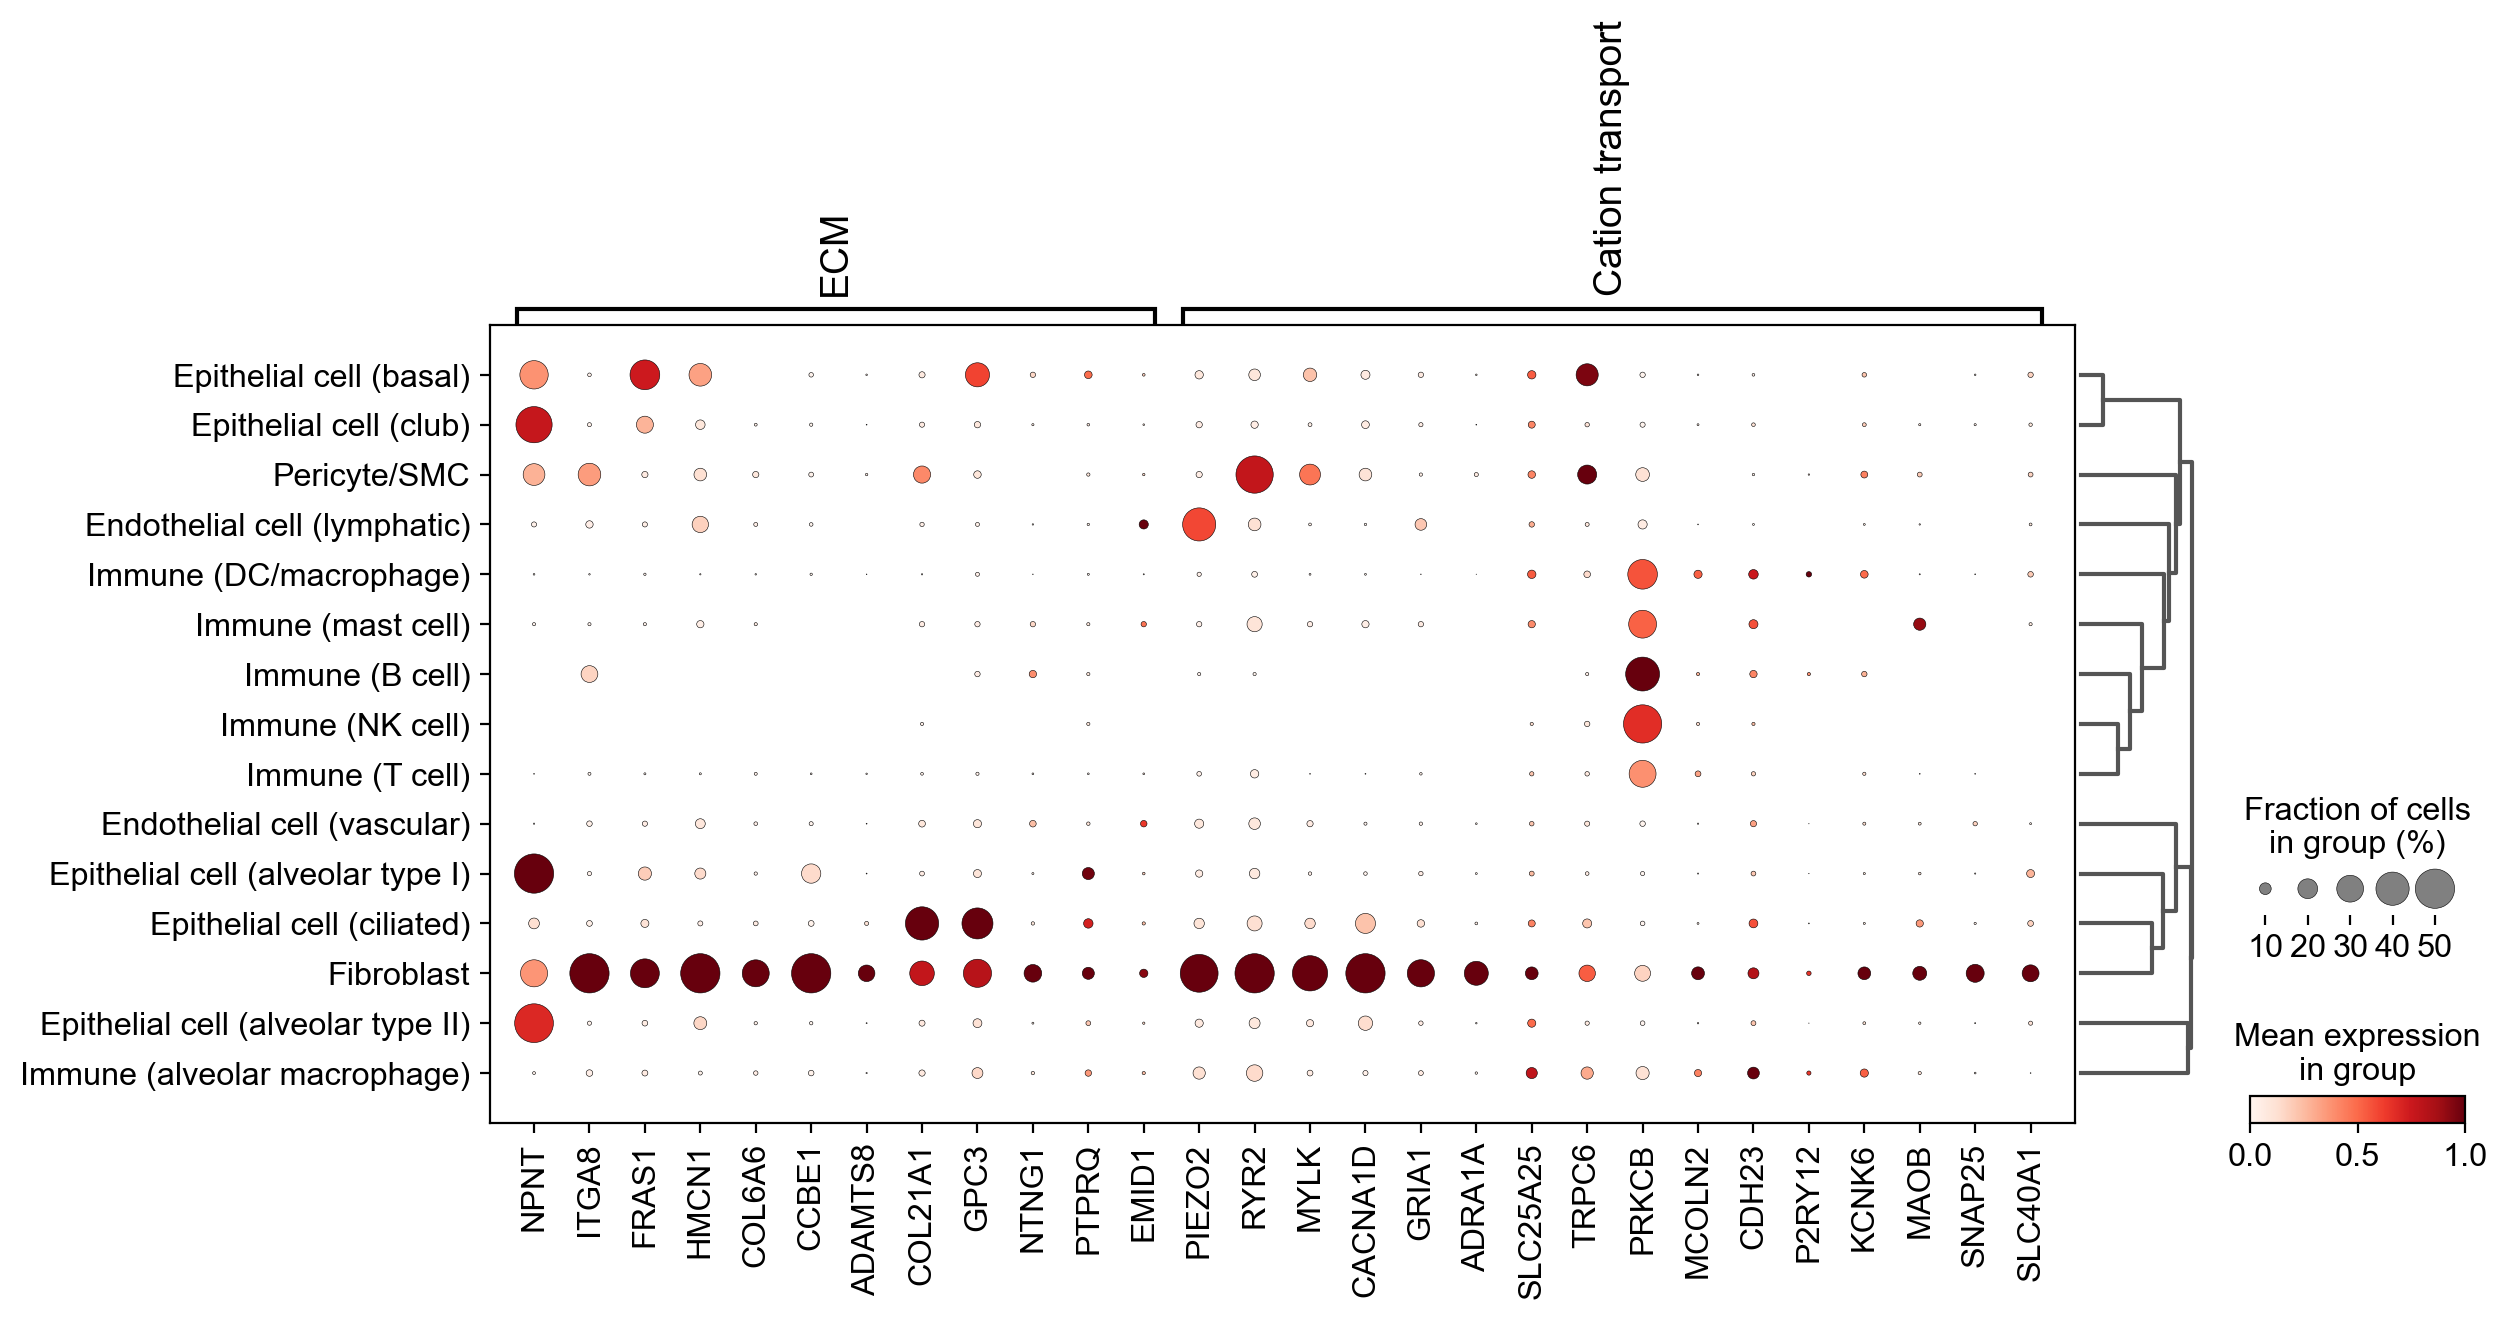

In [1269]:
sc.pl.dotplot(lung, go_gene_dict, 'Broad cell type', cmap='Reds', standard_scale='var', dot_max=.5, dendrogram=True)

In [1212]:
lung = adata[adata.obs.Tissue == 'Lung'].copy()
sc.pp.highly_variable_genes(lung, n_top_genes=1000, batch_key='individual')
sc.pp.pca(lung)
sc.tl.dendrogram(lung, 'Broad cell type', linkage_method='average', cor_method='spearman')

categories: Endothelial cell (lymphatic), Endothelial cell (vascular), Epithelial cell (alveolar type I), etc.
var_group_labels: ECM, Cation transport


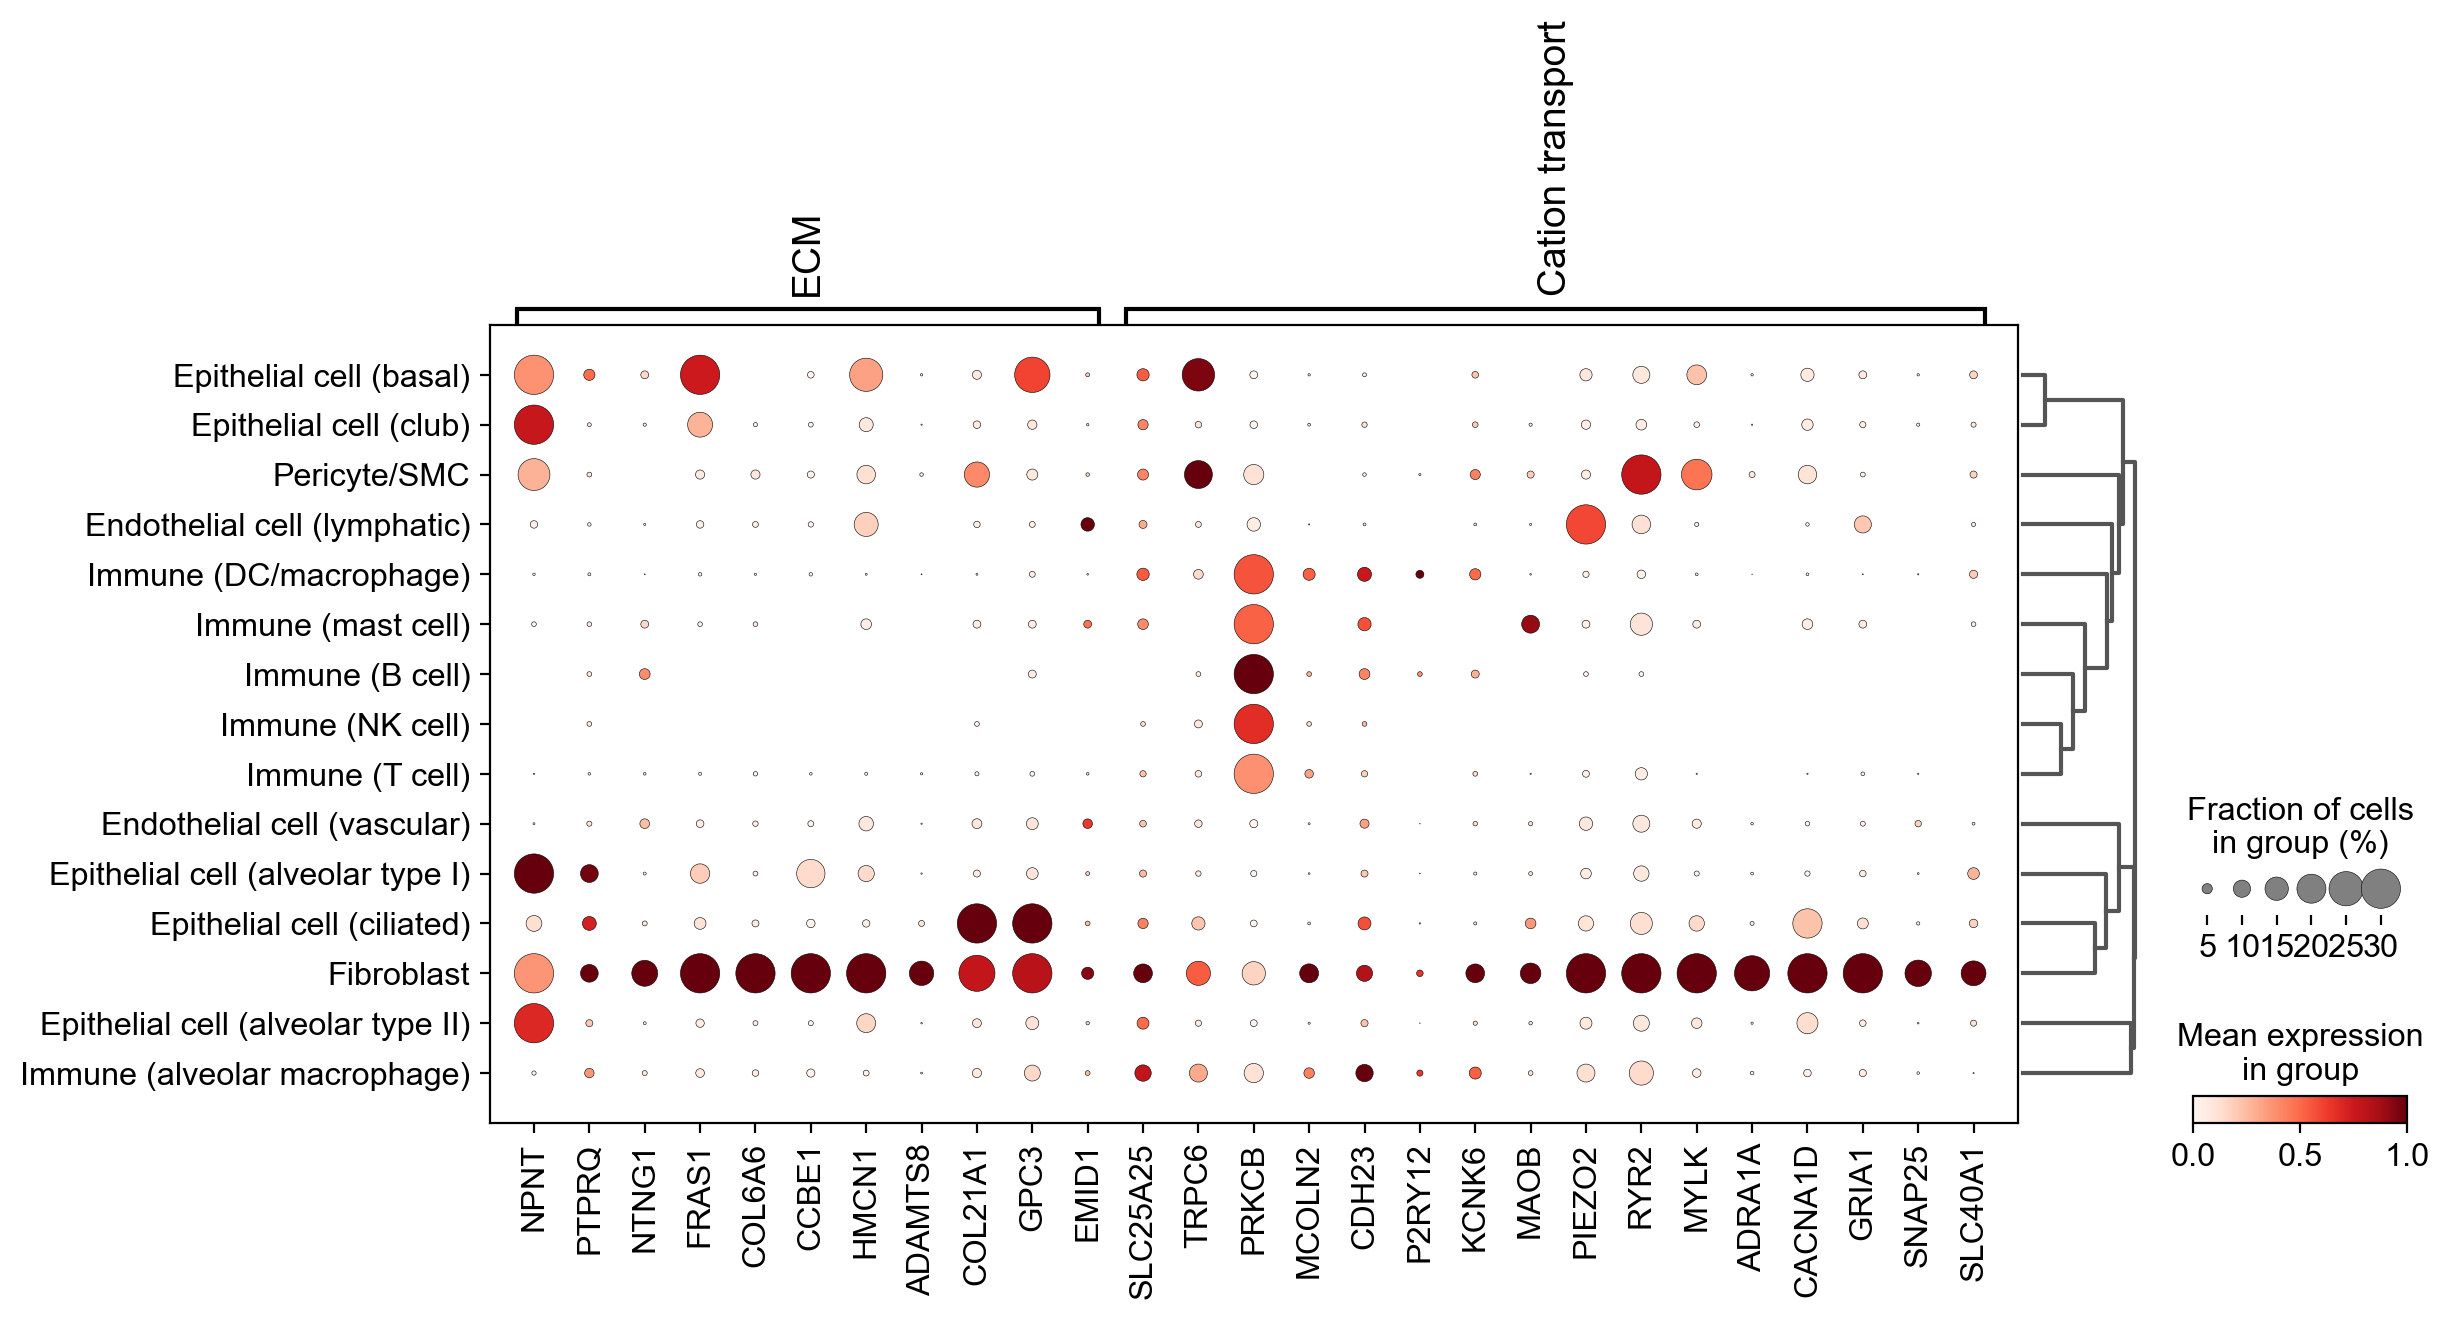

In [1223]:
genes = gos[gos.name == 'extracellular matrix'].intersections.iloc[0]
idx = sort_by_correlation(pd.DataFrame(lung[:, genes].X.A, columns=genes), rows=False)
genes = np.array(genes)[idx]
go_gene_dict['ECM'] = genes

genes = gos[gos.name == 'cation transport'].intersections.iloc[0]
idx = sort_by_correlation(pd.DataFrame(lung[:, genes].X.A, columns=genes), rows=False)
genes = np.array(genes)[idx]
go_gene_dict['Cation transport'] = genes

sc.pl.dotplot(lung, go_gene_dict, 'Broad cell type', cmap='Reds', standard_scale='var', dot_max=.3, dendrogram=True)